## Startup

Hidden Markov Models With Python (Gold example)  
https://medium.com/@natsunoyuki/hidden-markov-models-with-python-c026f778dfa7  
## 
   
  
Bloomberg: A PRACTICAL MODEL FOR PREDICTION OF INTRADAY VOLATILITY  
https://assets.bbhub.io/professional/sites/10/intraday_volatility-3.pdf?bbgsum-page=DG-WS-PROF-BLOG-POST-121973&tactic-page=429888

In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as web
import matplotlib.pyplot as plt
from hmmlearn import hmm

import os
import pickle

In [2]:
import yfinance as yf
yf.pdr_override()

In [28]:
np.random.seed(42)

In [29]:
dataroute=os.path.join("..",  "data")
resultsroute=os.path.join("..",  "results")

## Data Retrieval

In [4]:
tickerlist=["^MERV", 
            "GGAL", "GGAL.BA", 
            "YPF", "YPFD.BA",
            "EDN", "EDN.BA",
            "BMA", "BMA.BA"] 
# sumar tamb BBAR/BBAR? TEO/TECO2?

In [5]:
factordict={"GGAL": 10, "YPF":1, "EDN":20, "BMA":10, "BBAR":3, "TEO":5}

In [6]:
stocks=tickerlist.copy()
stocks.remove("^MERV")
stocklist=[]

for i in range(0, len(stocks), 2):
    stocklist.append((stocks[i], stocks[i+1]))
del stocks
stocklist

[('GGAL', 'GGAL.BA'), ('YPF', 'YPFD.BA'), ('EDN', 'EDN.BA'), ('BMA', 'BMA.BA')]

In [7]:
ohlclist=["Open", "High", "Low", "Close"]

In [8]:
objectlist=[]

for ticker in tickerlist:
    objectlist.append(yf.Ticker(ticker))    

In [9]:
# get historical market data
data={}
start='2013-01-01'
end="2023-06-01"

In [10]:
name=f'dataset_{start}_{end}_{str(tickerlist)}.pickle'
filename=os.path.join(dataroute, name)

In [11]:
if not os.path.exists(filename):
    for ticker in objectlist:
        # descargo data en un diccionario[ticker]
        data[ticker.ticker] = ticker.history(start=start, end=end)
        # guardo en un pickle
    with open(filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
            
else:
    with open(filename, 'rb') as handle:
        data=pickle.load(handle)

## Data quality deletion

In [12]:
data_quality_dates=["2022-07-14"]

In [13]:
for ticker in tickerlist:
    data[ticker]=data[ticker].loc[~data[ticker].index.isin(pd.to_datetime(data_quality_dates))]

## Implicit USD calculation

In [14]:
def _reindex_refill_dfs(df1, df2):
    """
    The function returns two dataframes with an index as the union of the two.
    The dataframes are then forward filled.
    """
    index3=df1.index.union(df2.index)
    # reindex both con index3
    df3=df1.reindex(index3)
    df4=df2.reindex(index3)
    # fillna con previous value
    df3.fillna(method="ffill")
    df4.fillna(method="ffill")
    return df3, df4

In [15]:
def calculate_usd(usd_df, ars_df, conversion_factor):
    """
    The function returns a dataframe with an index the size of the union between the two.
    Missing values in dates (stemming from, for example, holidays in one country) are
    forward filled to create the last  
    """
    usd_df_r, ars_df_r = _reindex_refill_dfs(usd_df, ars_df)
    implicit_usd = ars_df_r.divide(usd_df_r)*conversion_factor
    return implicit_usd

In [16]:
usdlist=[]
for stocktuplo in stocklist:
    us, ba = stocktuplo
    usdlist.append(f"USD_{us}")
    data[f"USD_{us}"]=calculate_usd(data[us][ohlclist], data[ba][ohlclist], factordict[us])
    data[f"USD_{us}"]["Average"]=data[f"USD_{us}"].mean(axis=1)

In [17]:
data["USD"]=pd.DataFrame(columns=ohlclist)

for i in ohlclist:
    df=pd.concat([data[col][i] for col in usdlist], axis=1)
    data["USD"][i]=df.mean(axis=1)
    
data["USD"]["Average"]=data["USD"].mean(axis=1)

In [18]:
for key in data.keys():
    data[key].fillna(method="ffill", inplace=True)
    # revisar esto

<AxesSubplot:xlabel='Date'>

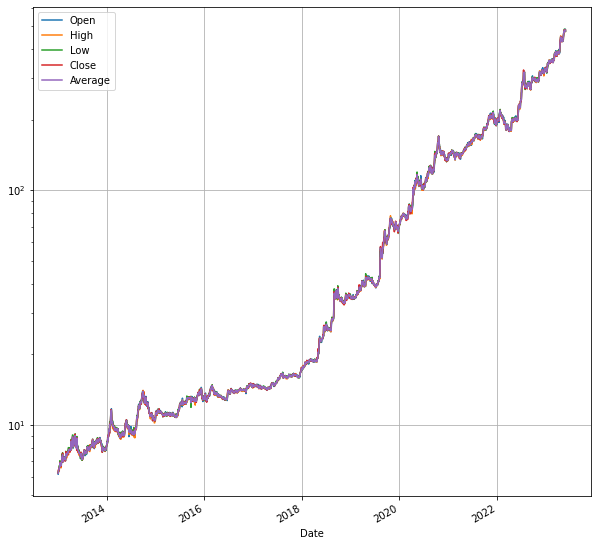

In [19]:
data["USD"][[*ohlclist, "Average"]].plot(figsize=(10,10), logy=True, grid=True)

## USD Denominated Index

In [20]:
data["USD_^MERV"]=pd.DataFrame(columns=ohlclist)

for col in ohlclist:
    data["USD_^MERV"][col] = data["^MERV"][col]/data["USD"]["Average"]

In [21]:
data["USD_^MERV"].fillna(method="ffill", inplace=True)

## Intraday Volatility

Vamos a usar para medir intraday volatility el estimador de Garman and Klass (1980):

$$V_{ohlc}=0.5*[log(H)-log(L)]^2+(2*log(2)-1)*[log(C)-log(O)]^2$$ 
Donde H es el precio mas alto del día, L el bajo, C el cierre y O su apertura

Garman, M. B. and M. J. Klass (1980). On the estimation of security price volatilities from historical data. Journal of Business 53, 67–78.

In [22]:
def gk_vol(o, h, l, c):
    "Returns Garman Klass (1980) intraday volatility estimator"
    return 0.5*(np.log(h)-np.log(l))**2+(2*np.log(2)-1)*(np.log(c)-np.log(o))**2

## Returns Calculation

In [23]:
for ticker in data.keys():
    view=data[ticker]
    view["rets"] = view["Close"]/view["Close"].shift()-1
    view["log_rets"] = np.log(view["Close"]/view["Close"].shift())
    view["norm_range"] = (view["High"]-view["High"])/view["Open"]
    # chequear si esto tiene asidero
    # alternativa (view["High"]-view["High"])/view["Close"]
    view["gk_vol"] = gk_vol(o=view["Open"], h=view["High"], l=view["Low"], c=view["Close"])
    # delete first observation to eliminate nans
    data[ticker]=data[ticker][1:].copy()

## Descriptive Statistics

In [24]:
# TBD

## HMM Training

In [25]:
models={}
comps=[2,3,4]

for key in data.keys():
    print(key)
    for comp in comps:
        print(comp)
        modelname=f"{key}_{comp}_model"
        predictionname=f"{key}_{comp}_prediction"
        
        X = data[key]["log_rets"].values.reshape(-1,1)
        # univariate linear returns
        models[modelname]=hmm.GaussianHMM(n_components = comp, 
                                                       covariance_type = "full", 
                                                       n_iter = 50,
                                                       random_state = 42)
        models[modelname].fit(X)
        models[predictionname]=models[modelname].predict(X)

^MERV
2
3


Model is not converging.  Current: 6033.620258382727 is not greater than 6033.621679688544. Delta is -0.0014213058166205883


4
GGAL
2
3
4
GGAL.BA
2
3
4
YPF
2
3
4
YPFD.BA
2
3
4


Model is not converging.  Current: 4760.657706086924 is not greater than 4760.657721425884. Delta is -1.5338960110966582e-05


EDN
2
3
4
EDN.BA
2
3
4
BMA
2
3
4
BMA.BA
2
3
4
USD_GGAL
2
3
4
USD_YPF
2
3
4
USD_EDN
2
3
4
USD_BMA
2
3
4
USD
2
3
4
USD_^MERV
2
3
4


In [26]:
# Predict the hidden states corresponding to observed X.
for key in data.keys():
    for comp in comps:
        print(">"*30, key)
        model=models[f"{key}_{comp}_model"]
        prediction=models[f"{key}_{comp}_prediction"]
        print("unique states: ", pd.unique(prediction))
        print("\nStart probabilities:")
        print(model.startprob_)
        print("\nTransition matrix:")
        print(model.transmat_)
        print("\nGaussian distribution means:")
        print(model.means_)
        print("\nGaussian distribution covariances:")
        print(model.covars_)
        print()

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [0 1]

Start probabilities:
[1.00000000e+00 4.59659071e-18]

Transition matrix:
[[0.98208615 0.01791385]
 [0.15276138 0.84723862]]

Gaussian distribution means:
[[ 0.00264448]
 [-0.00460933]]

Gaussian distribution covariances:
[[[0.00035851]]

 [[0.00316436]]]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [2 0 1]

Start probabilities:
[2.35715555e-27 1.06525216e-21 1.00000000e+00]

Transition matrix:
[[0.01664521 0.98169764 0.00165715]
 [0.63771364 0.13298804 0.22929832]
 [0.01827419 0.0019057  0.97982011]]

Gaussian distribution means:
[[-4.51153568e-05]
 [-6.26468220e-03]
 [ 2.74079323e-03]]

Gaussian distribution covariances:
[[[0.00137592]]

 [[0.00366693]]

 [[0.00033856]]]

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> ^MERV
unique states:  [2 0 1 3]

Start probabilities:
[8.08154215e-007 1.55266098e-050 9.99999192e-001 2.02610913e-207]

Transition matrix:
[[2.14161920e-001 2.53043121e-006 7.85835549e-001 7.37413602e-013]
 [1.3296446

C:\Users\Alfred\Anaconda3\envs\pythonforfinance\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


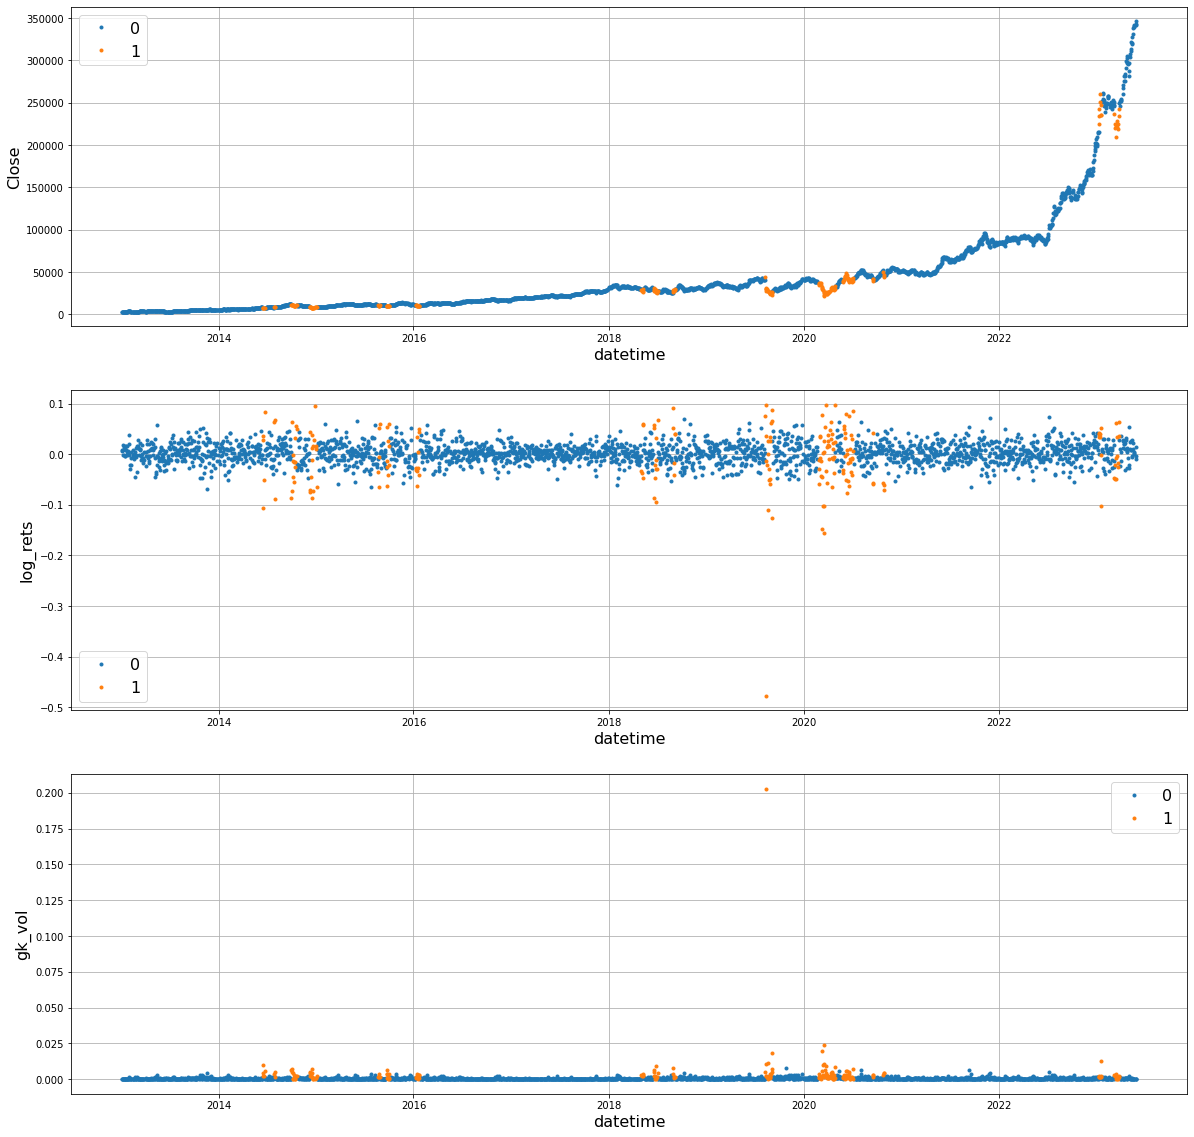

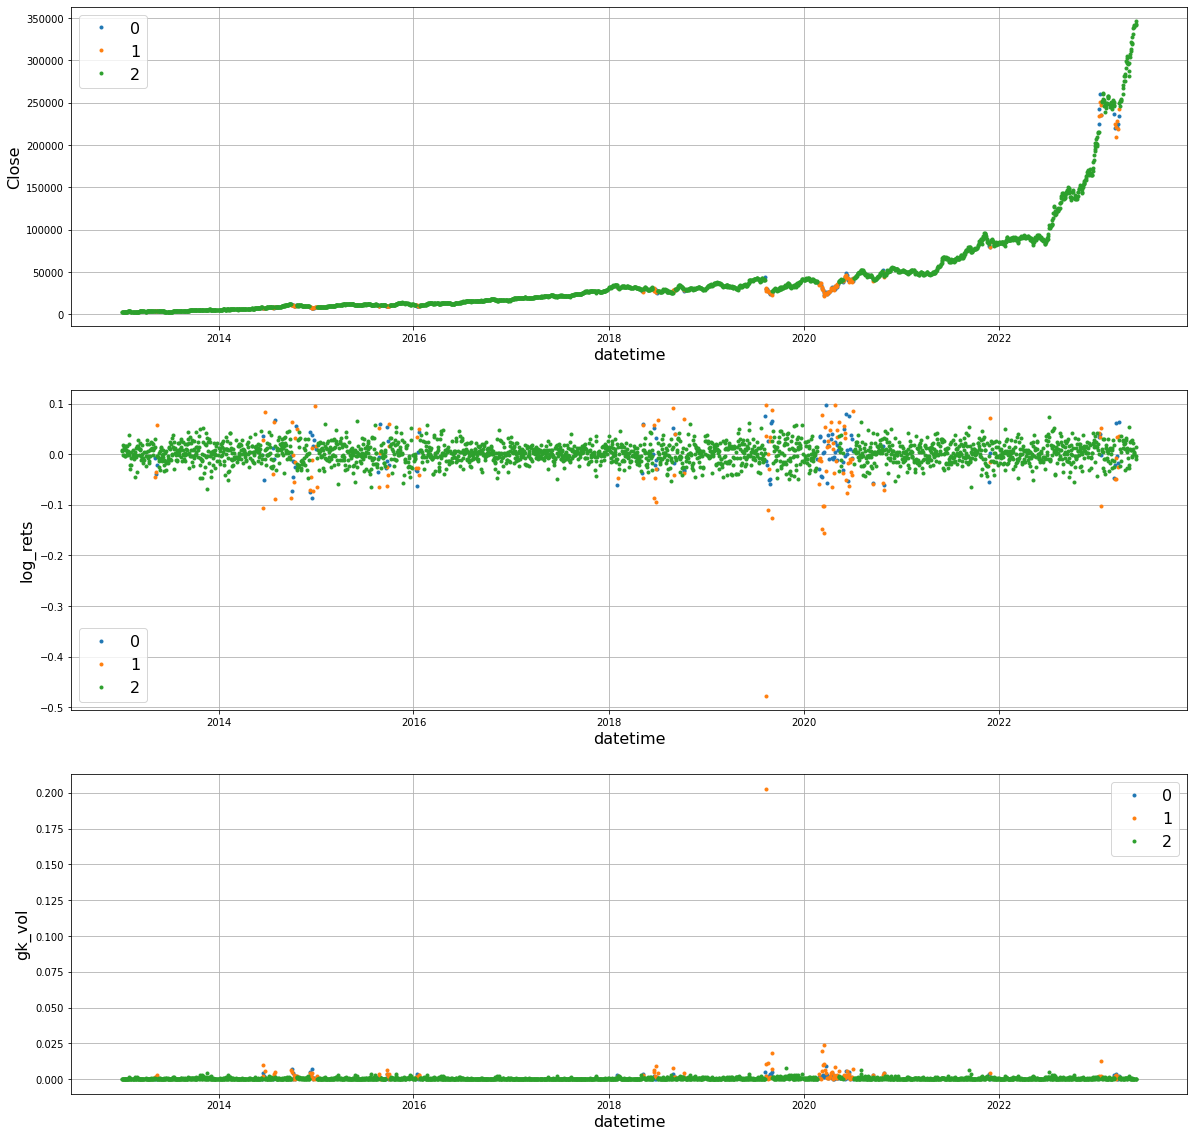

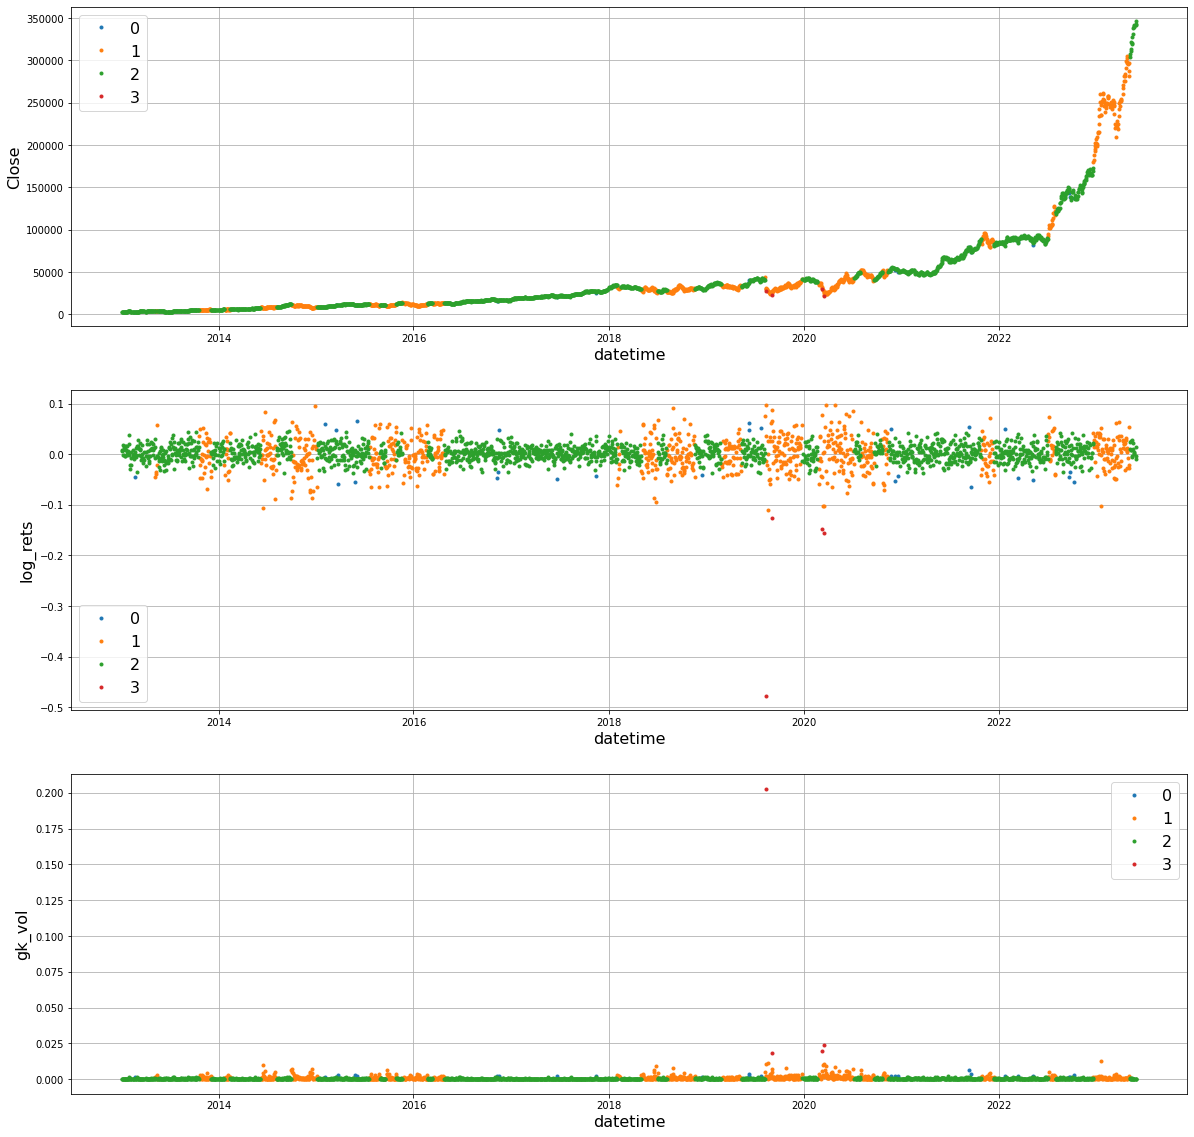

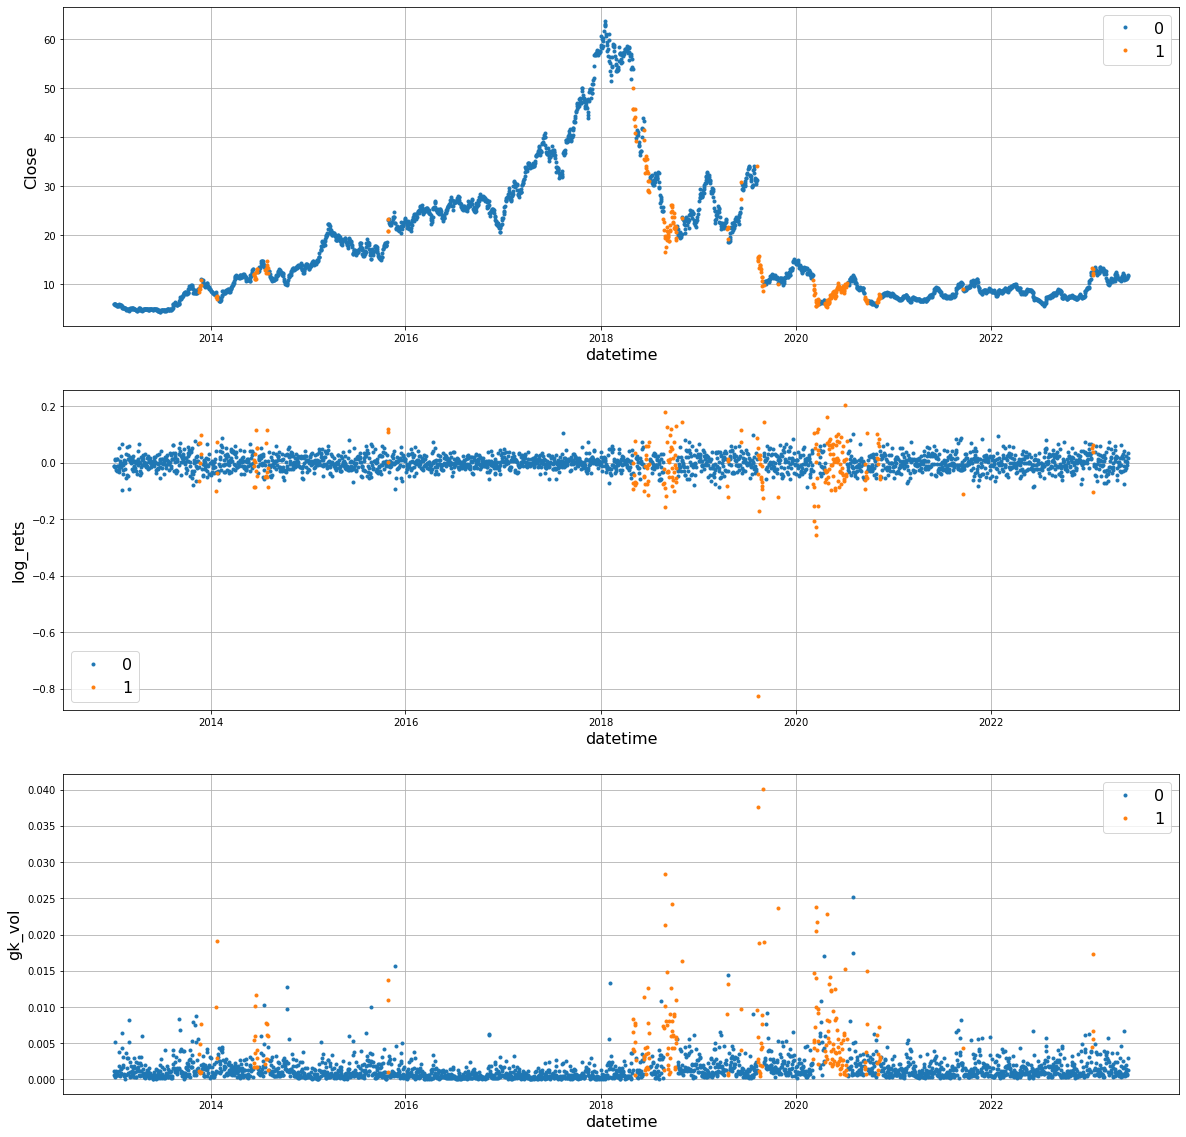

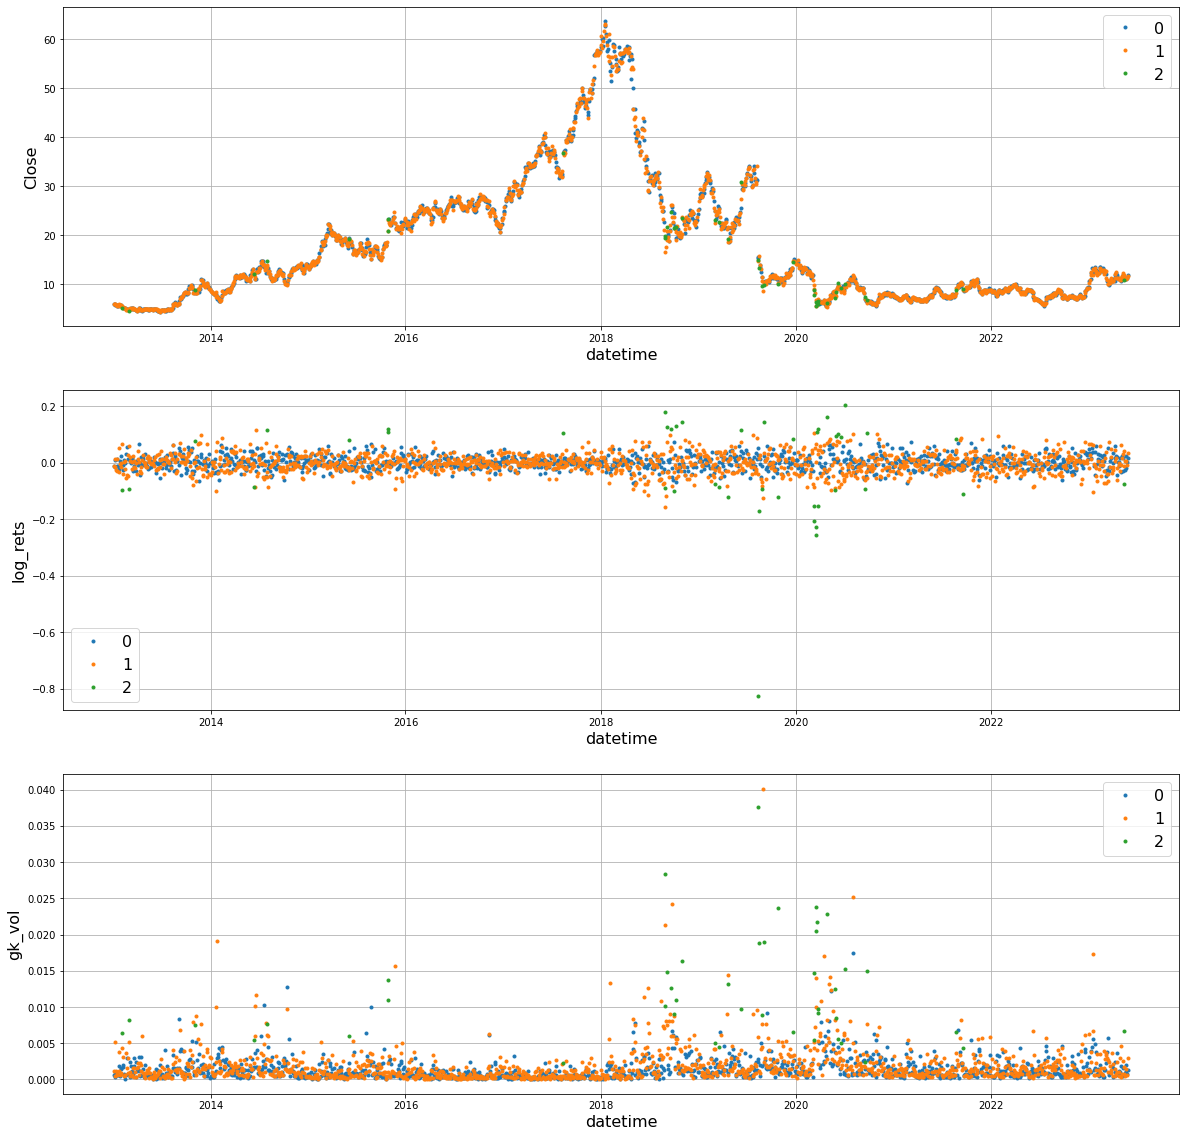

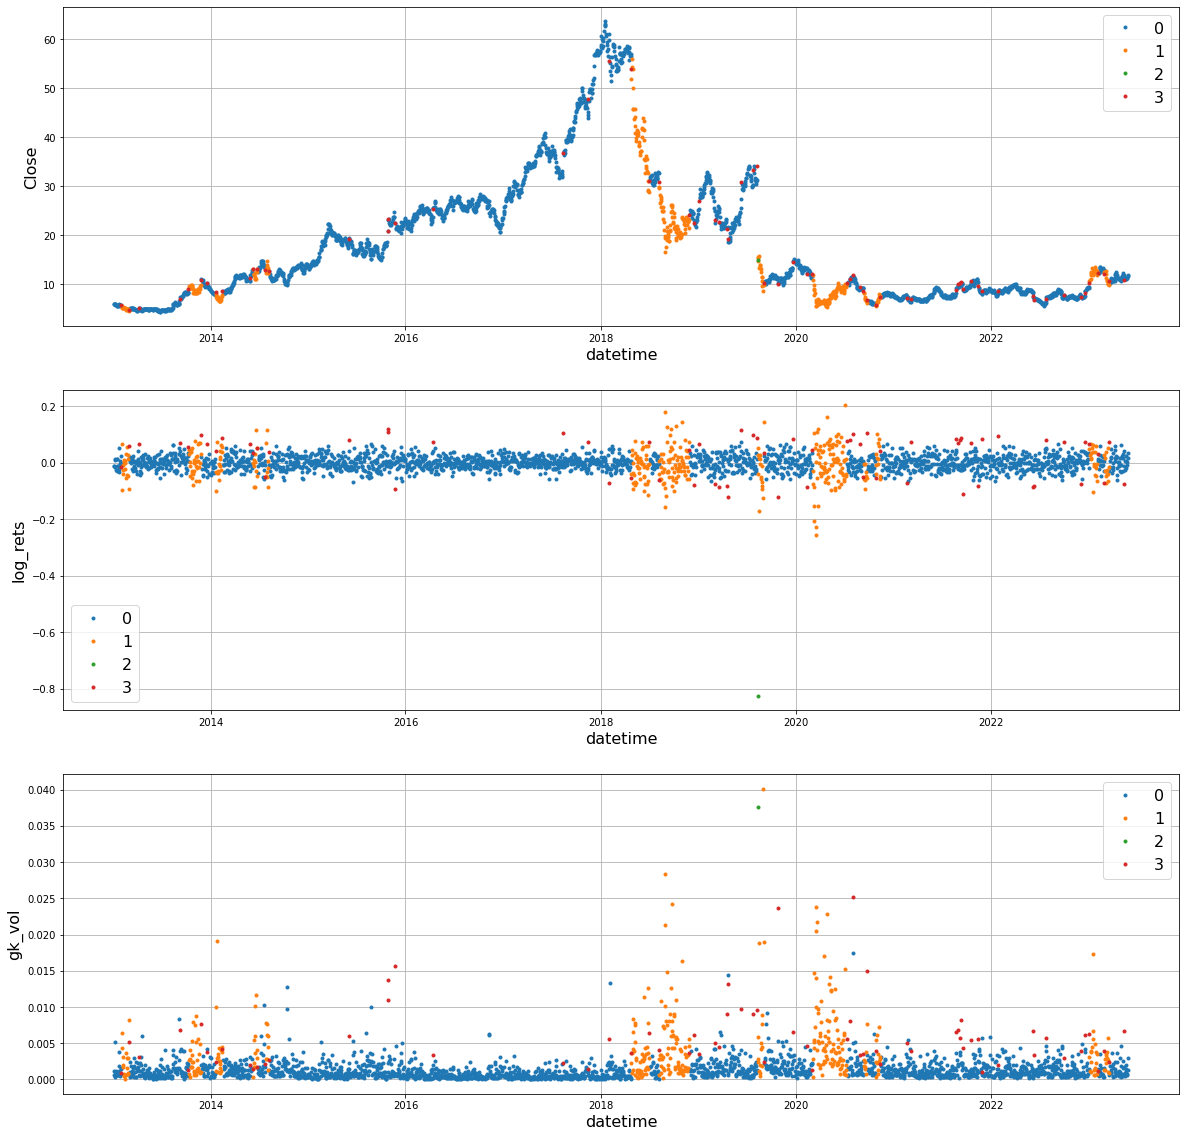

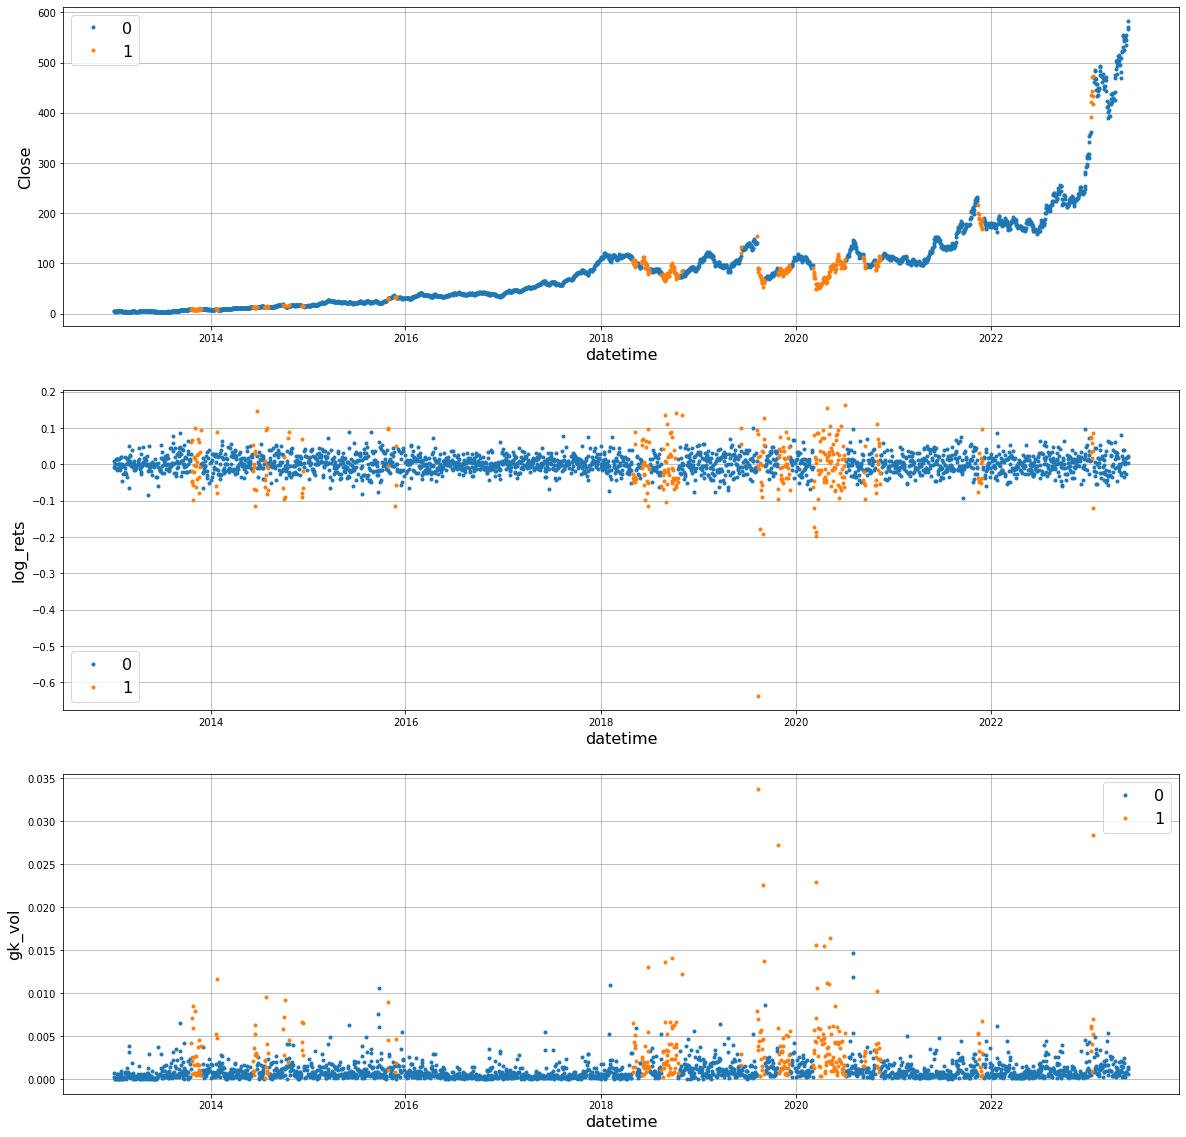

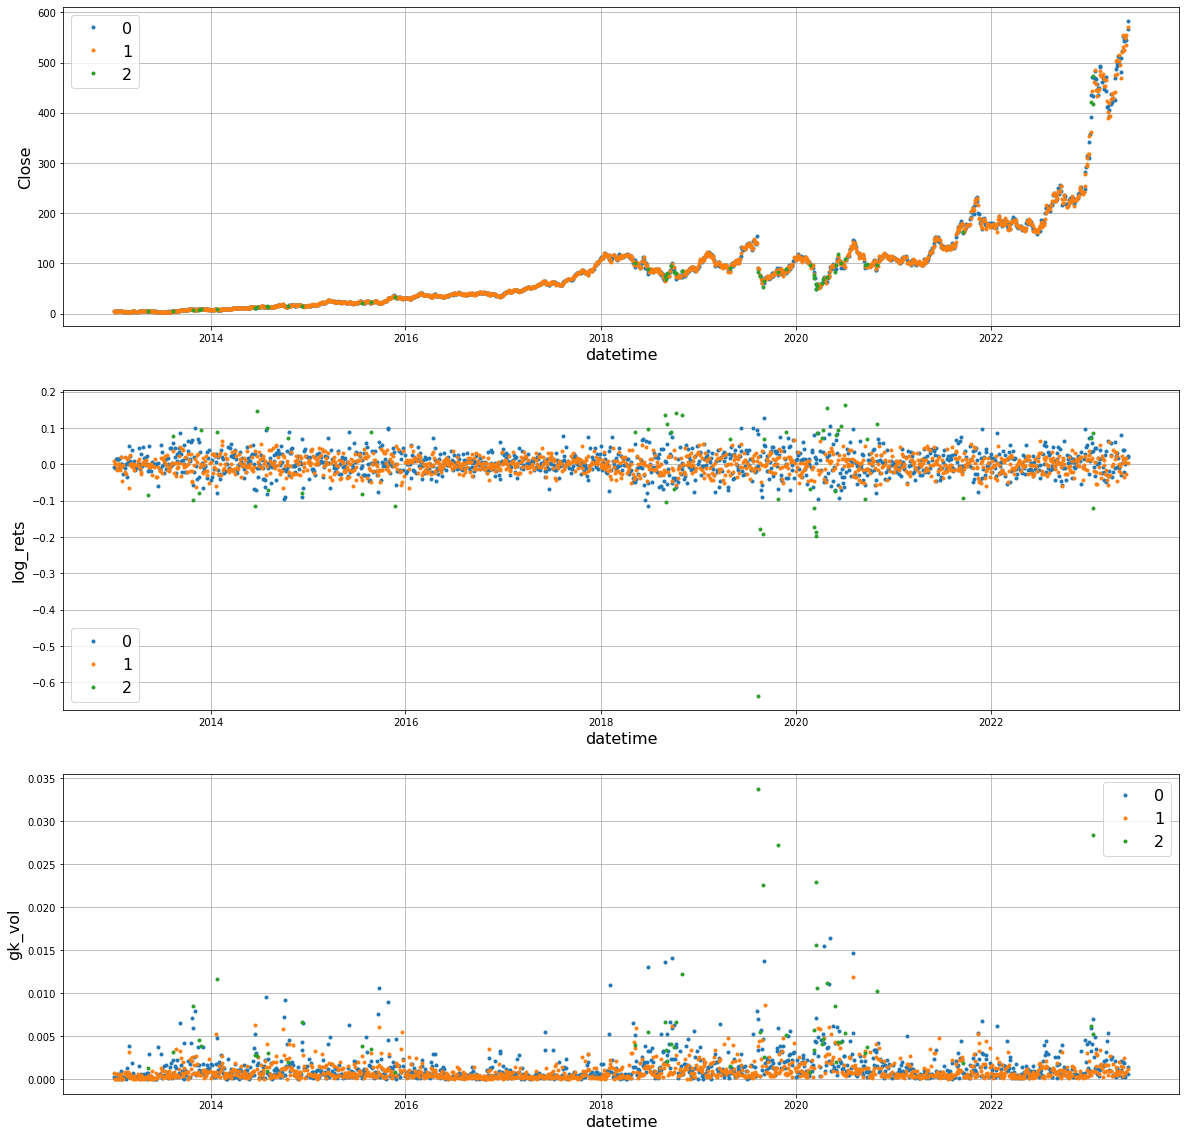

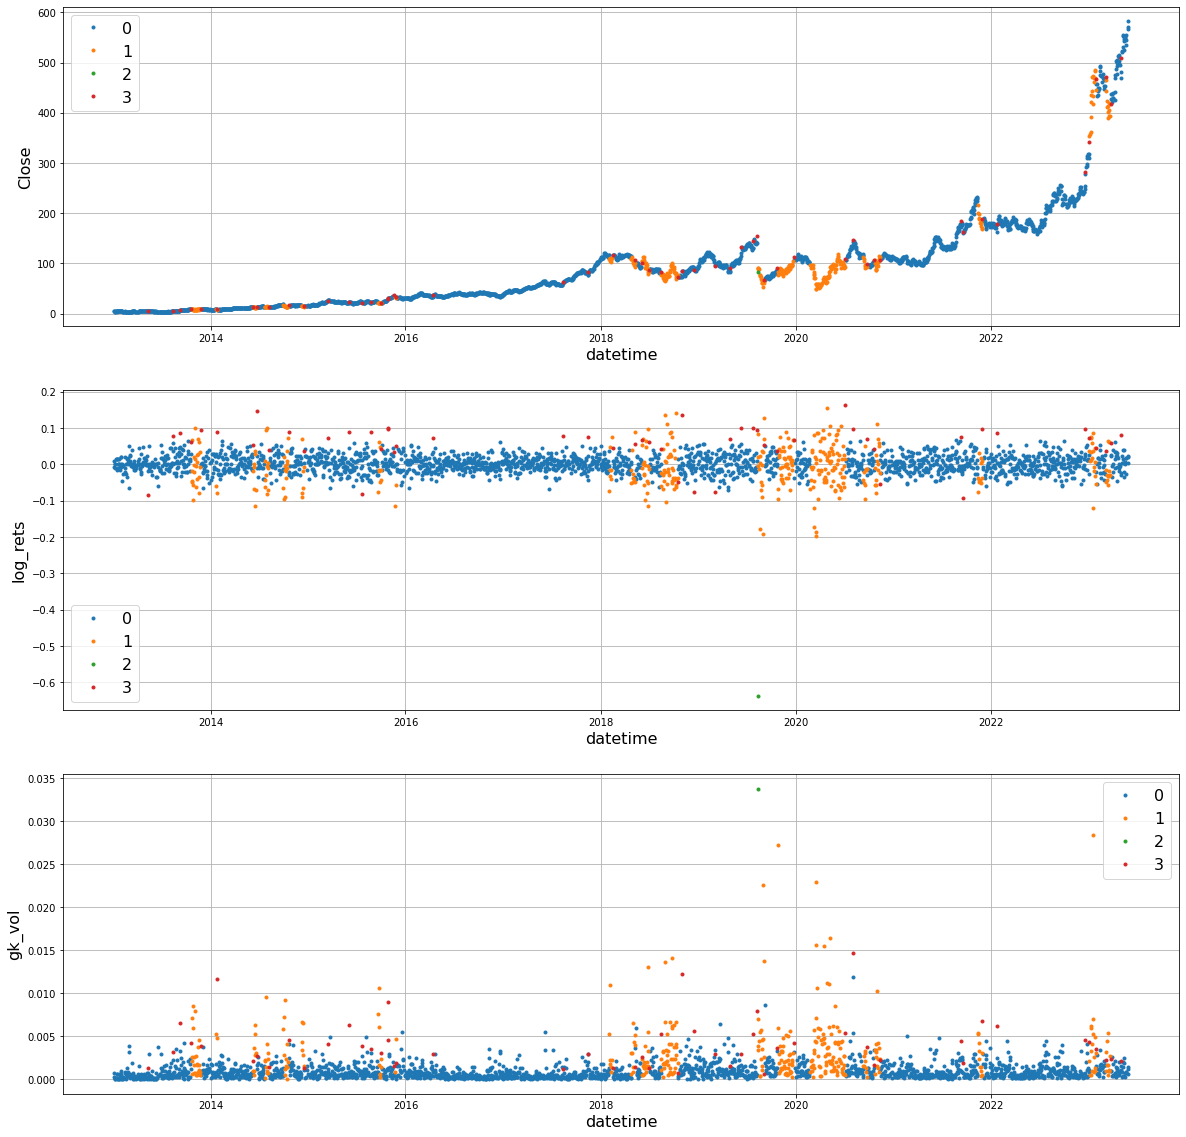

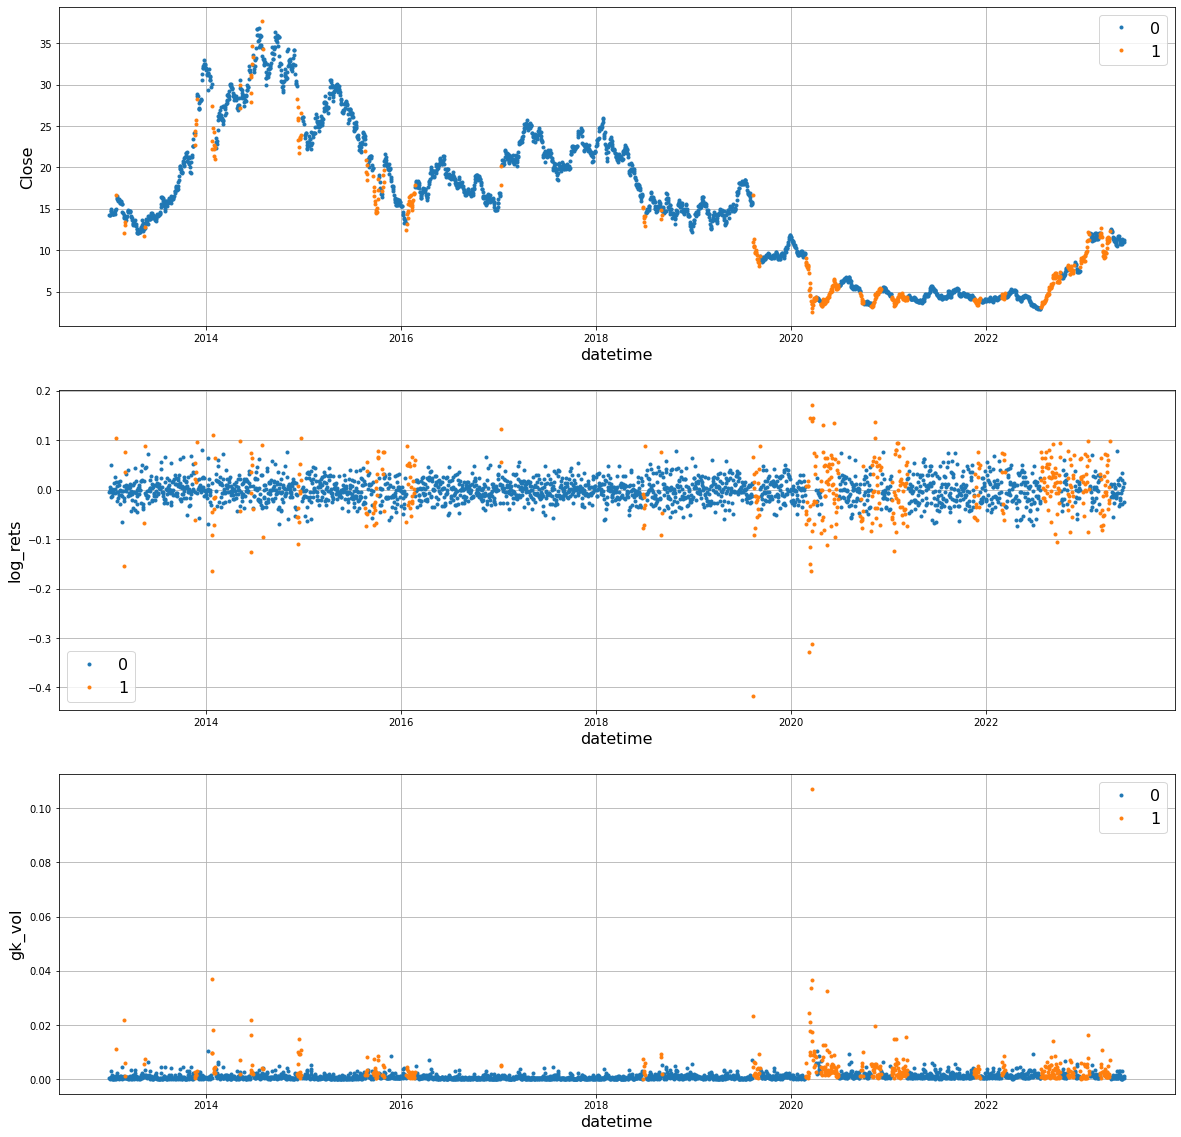

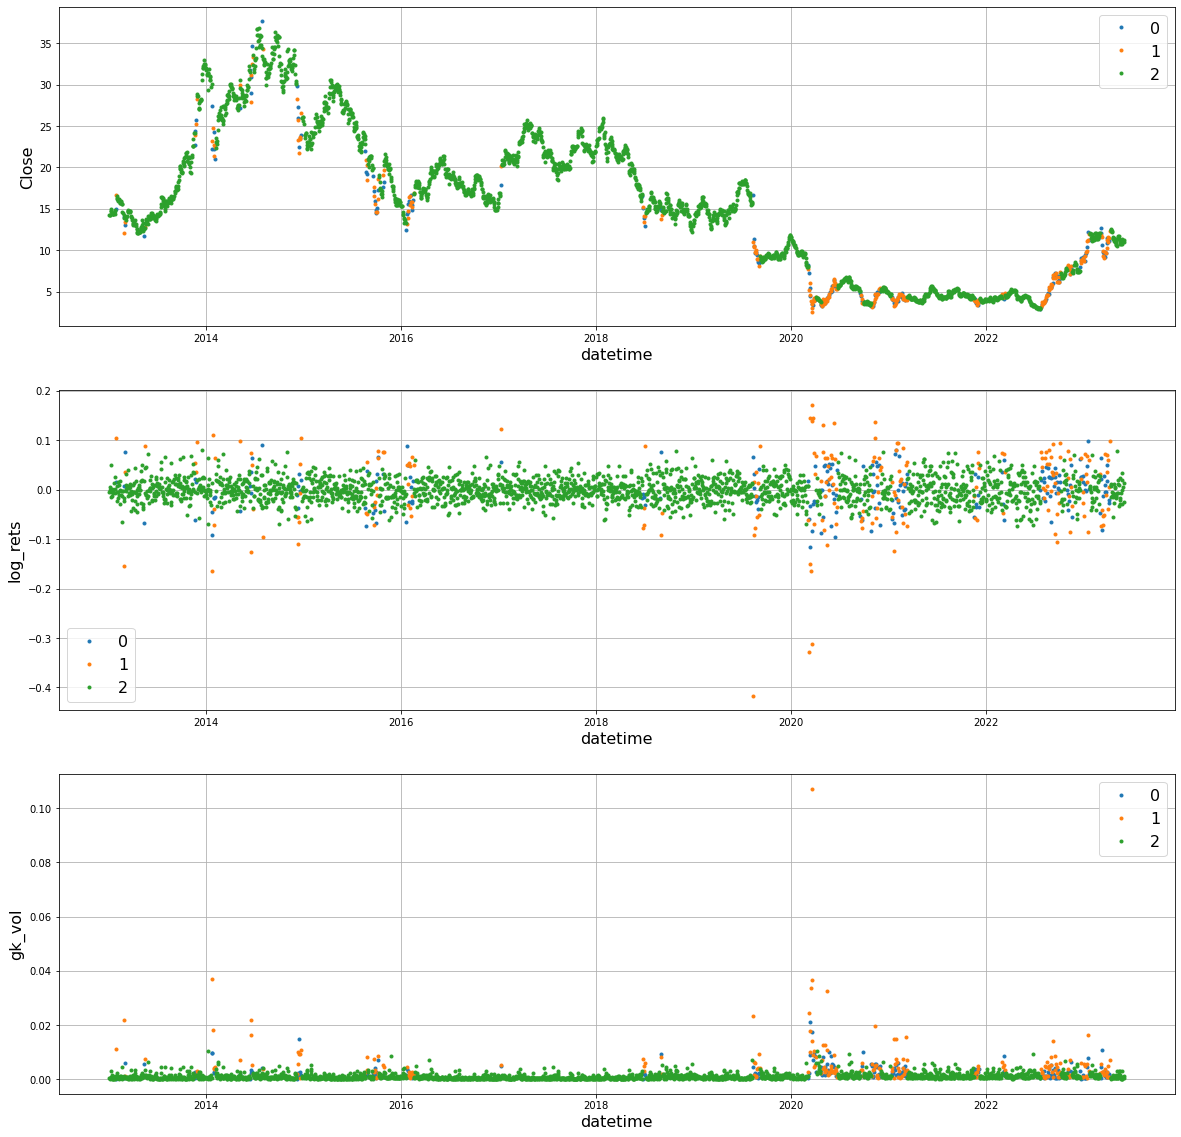

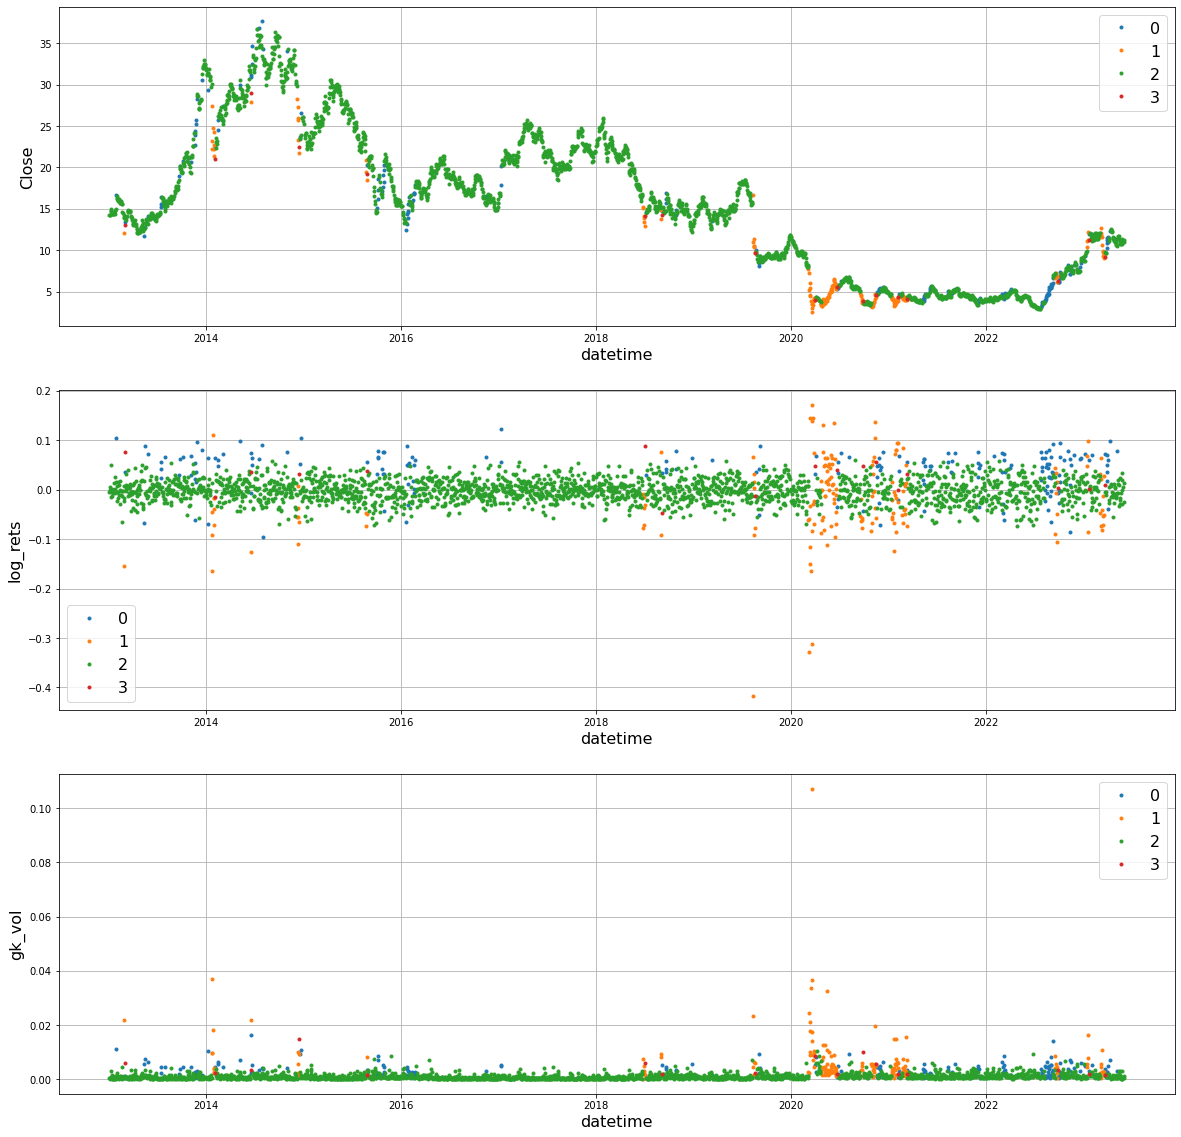

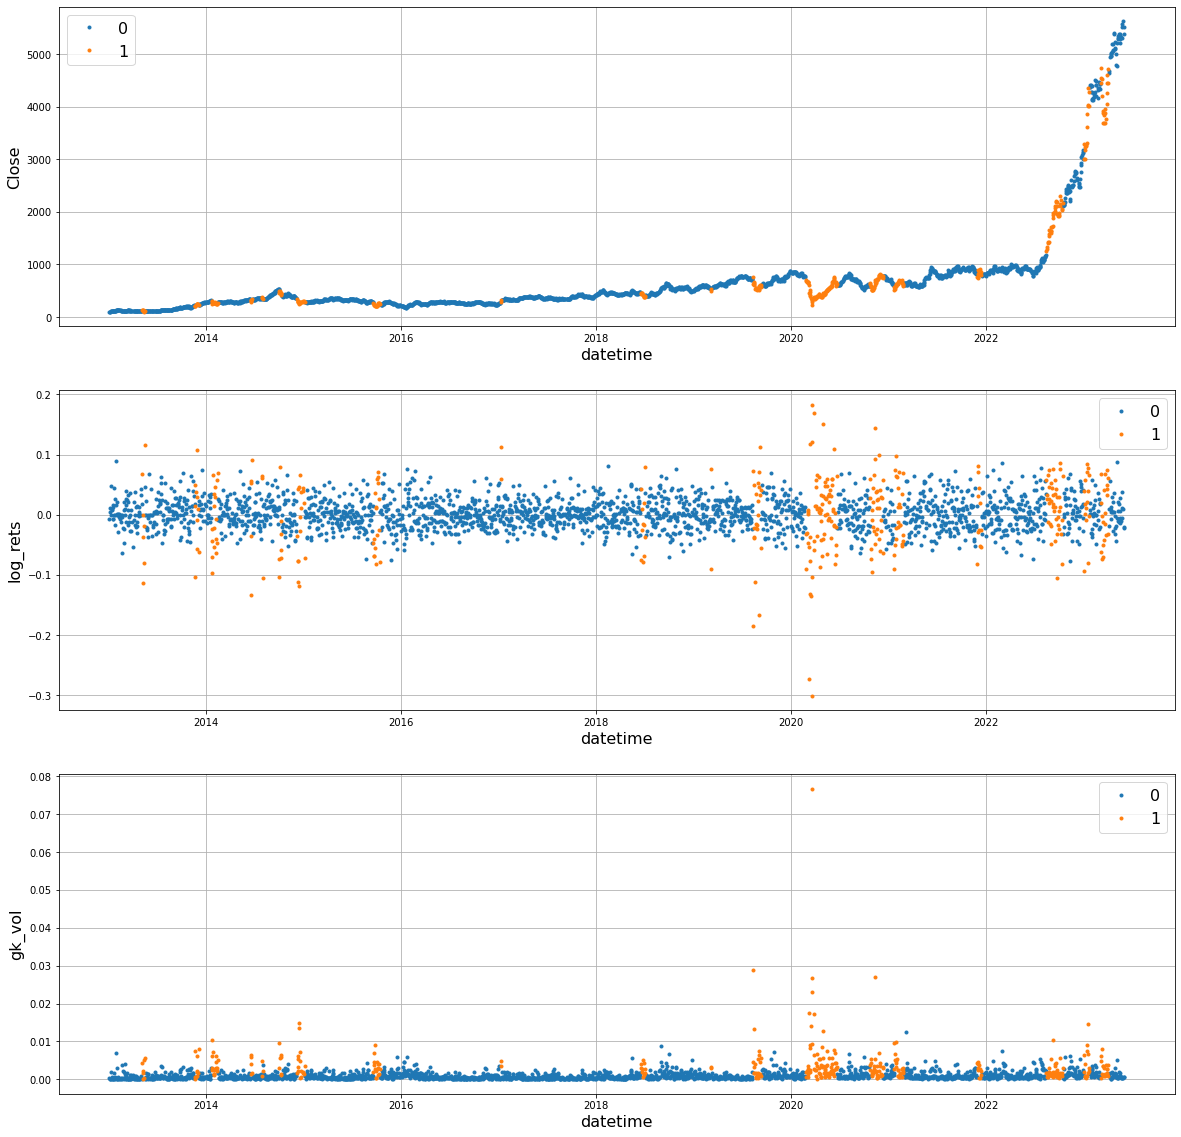

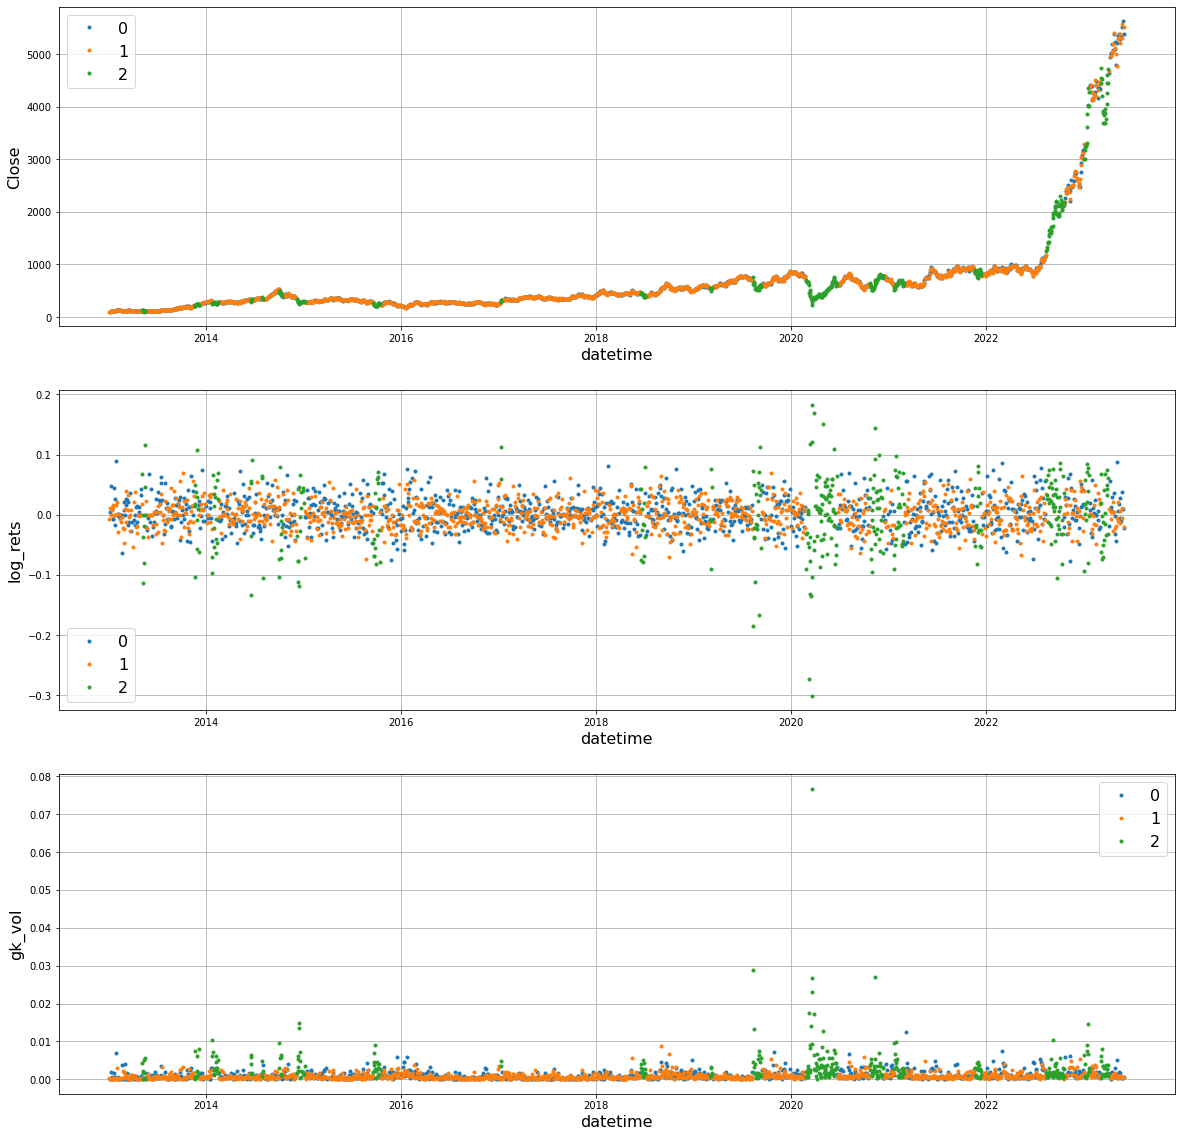

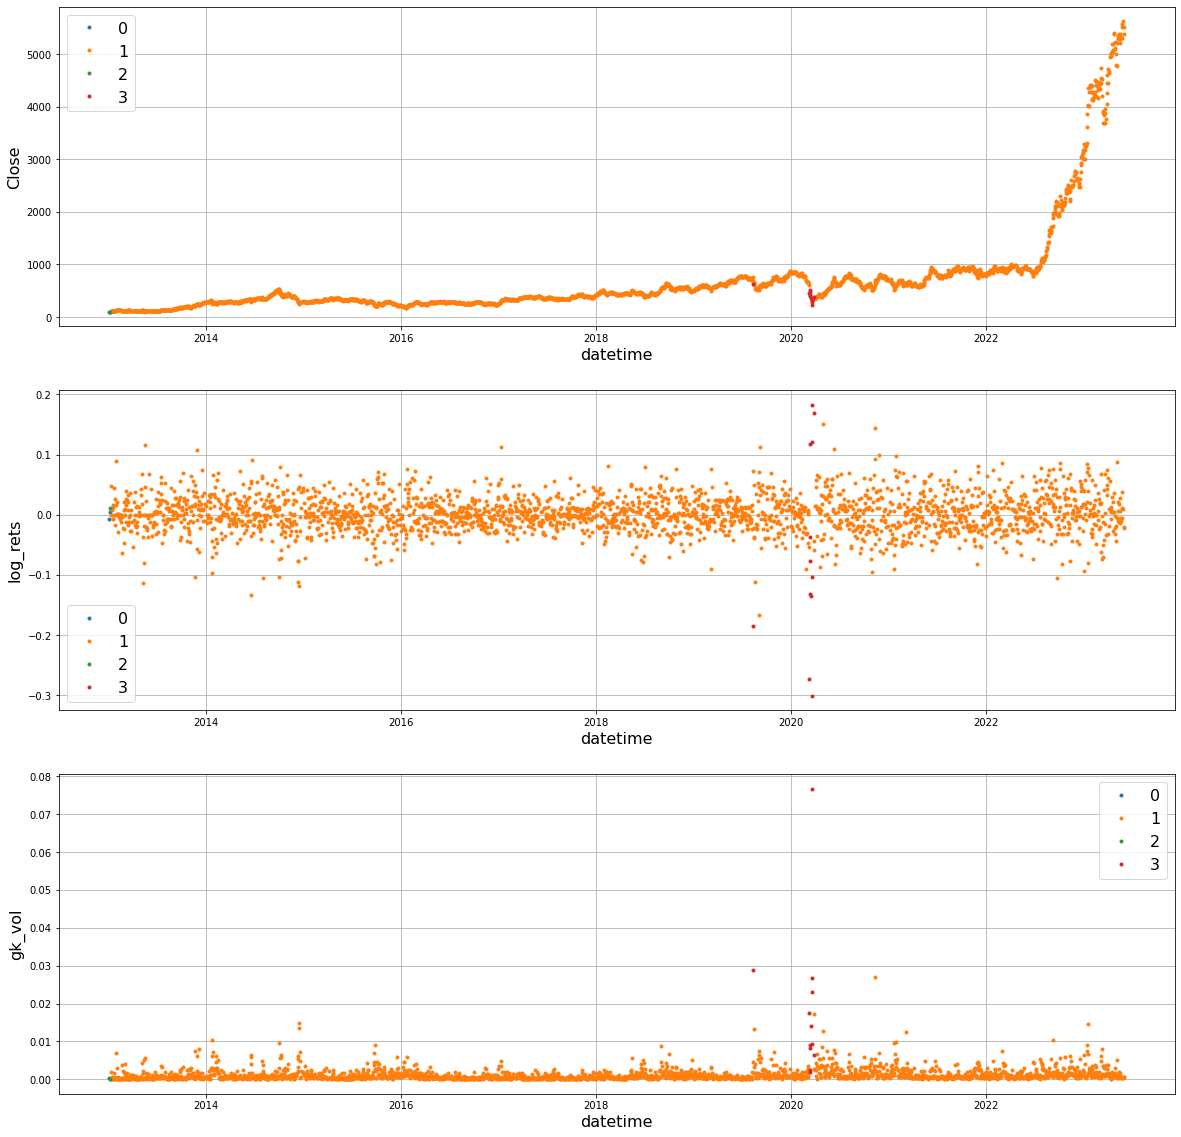

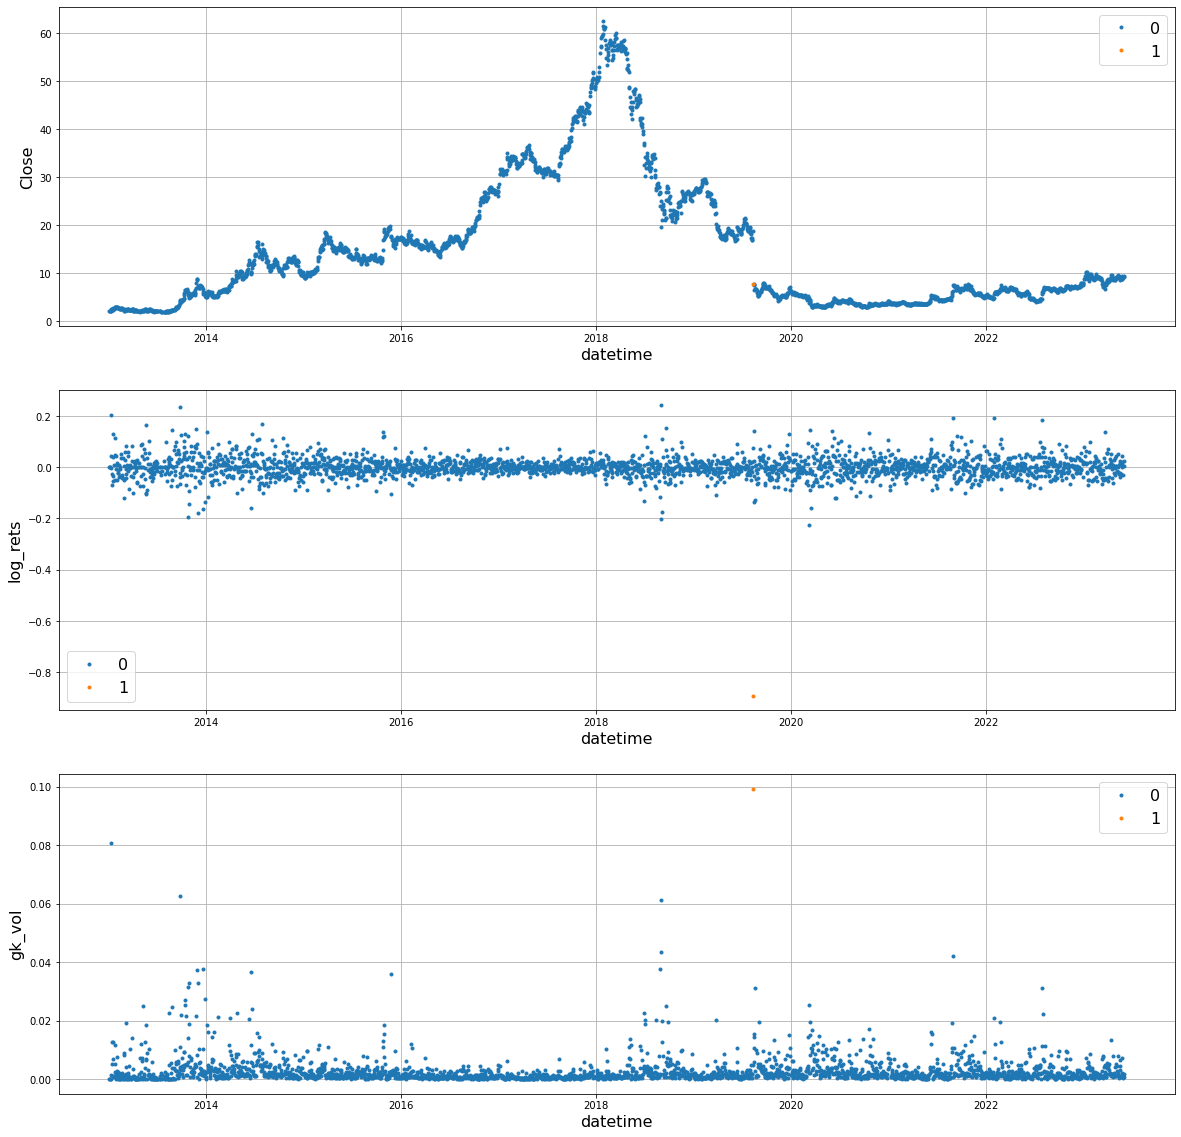

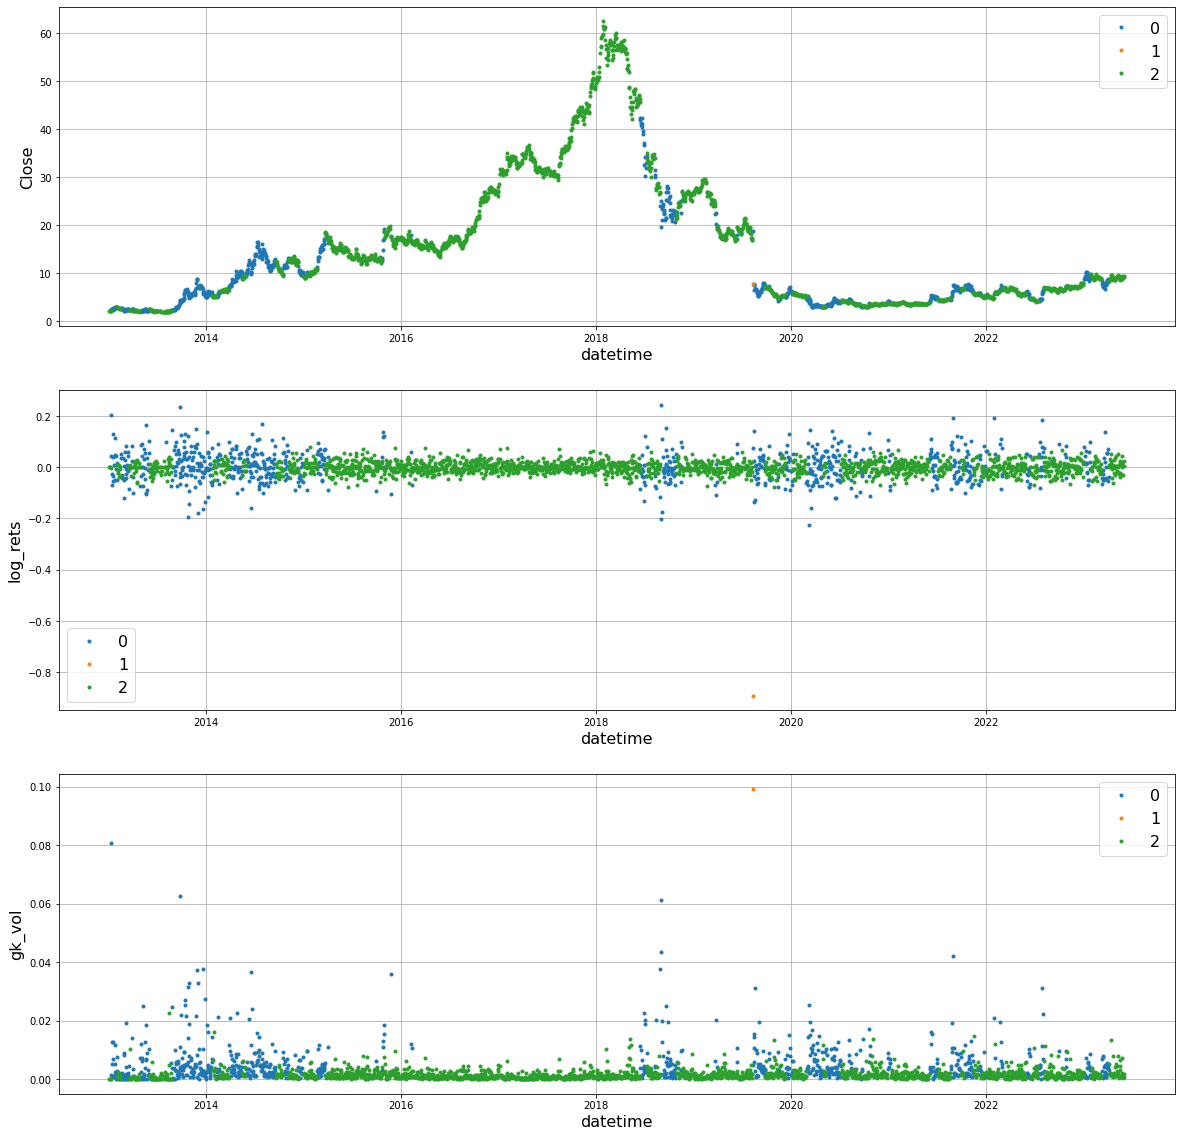

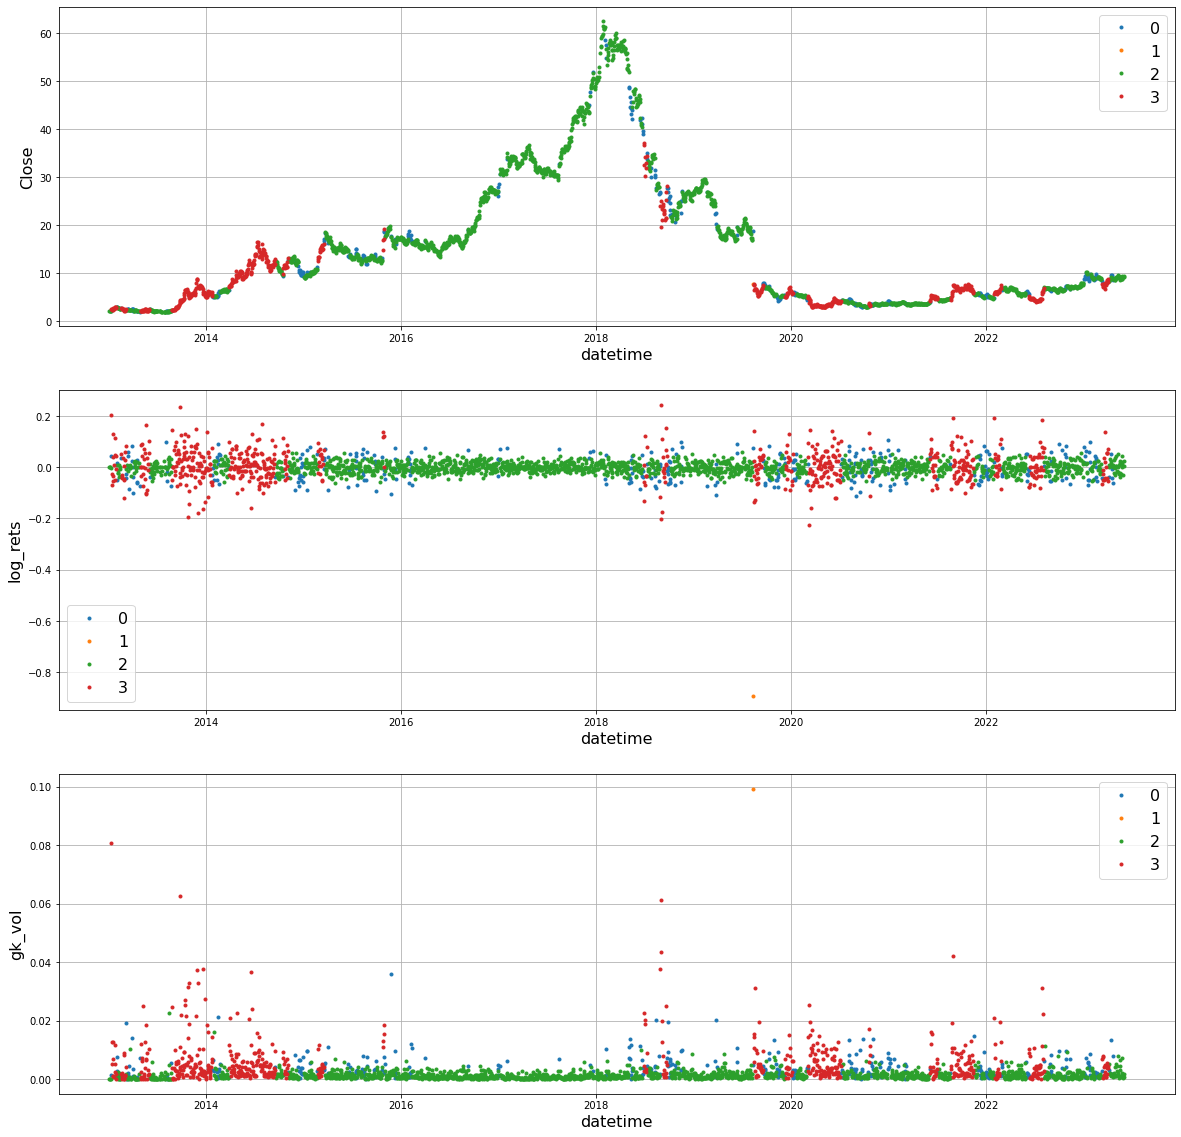

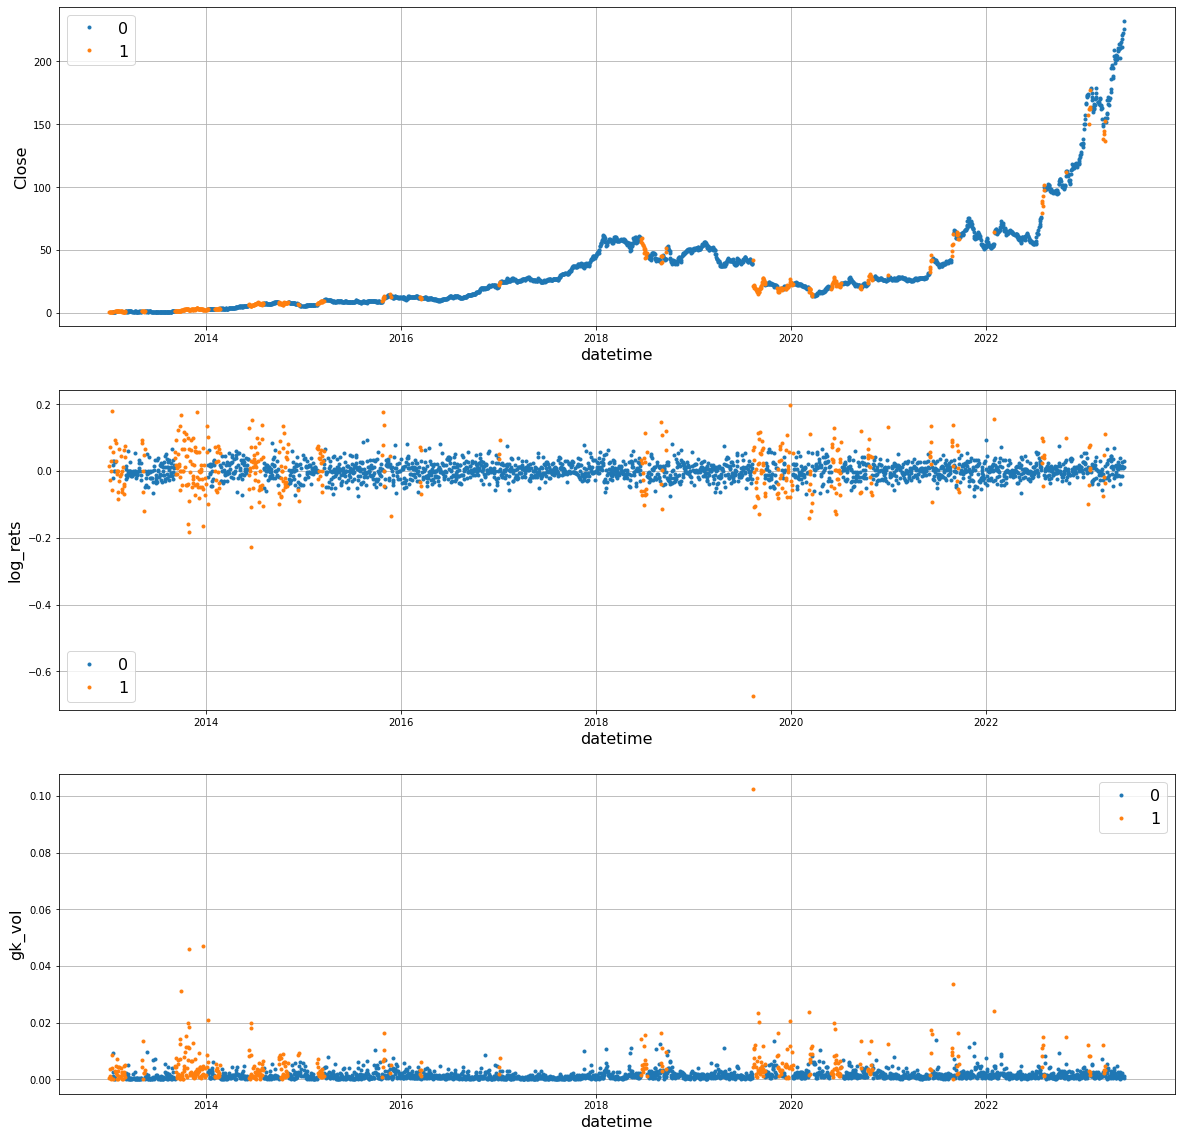

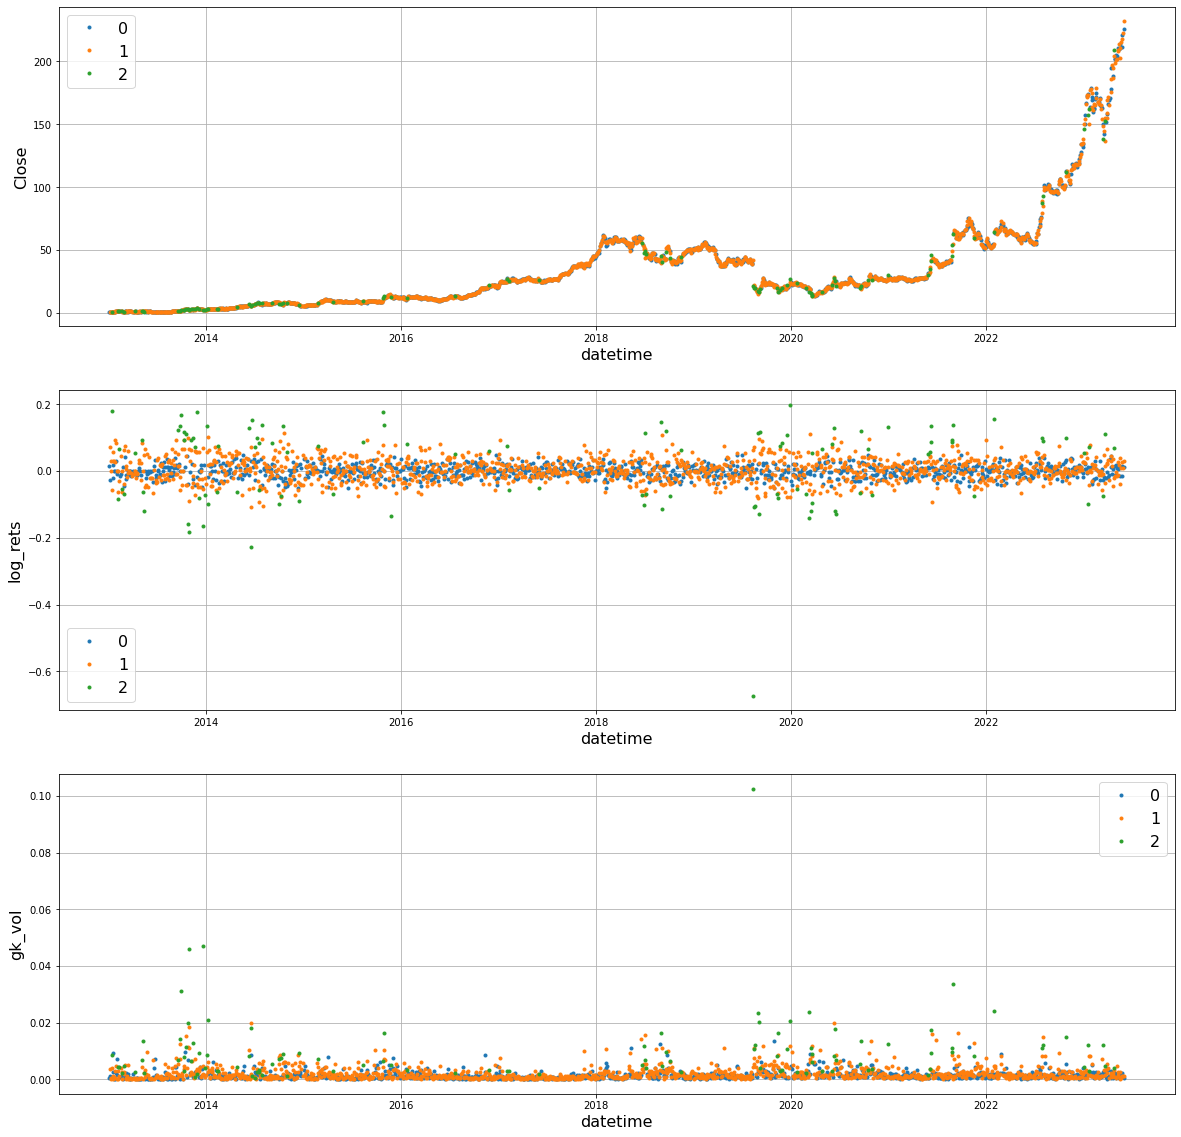

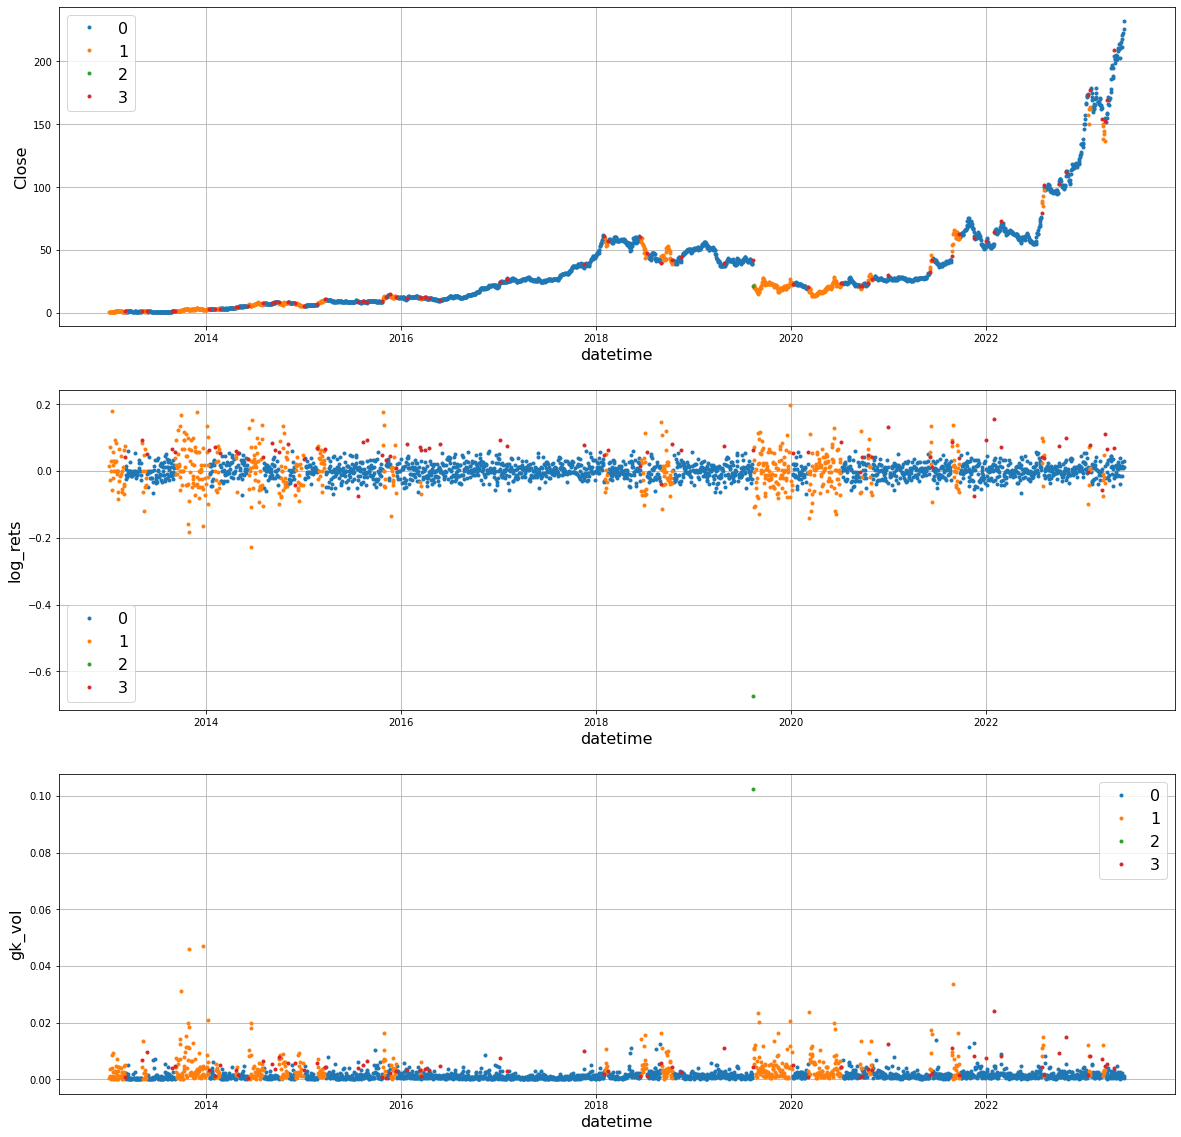

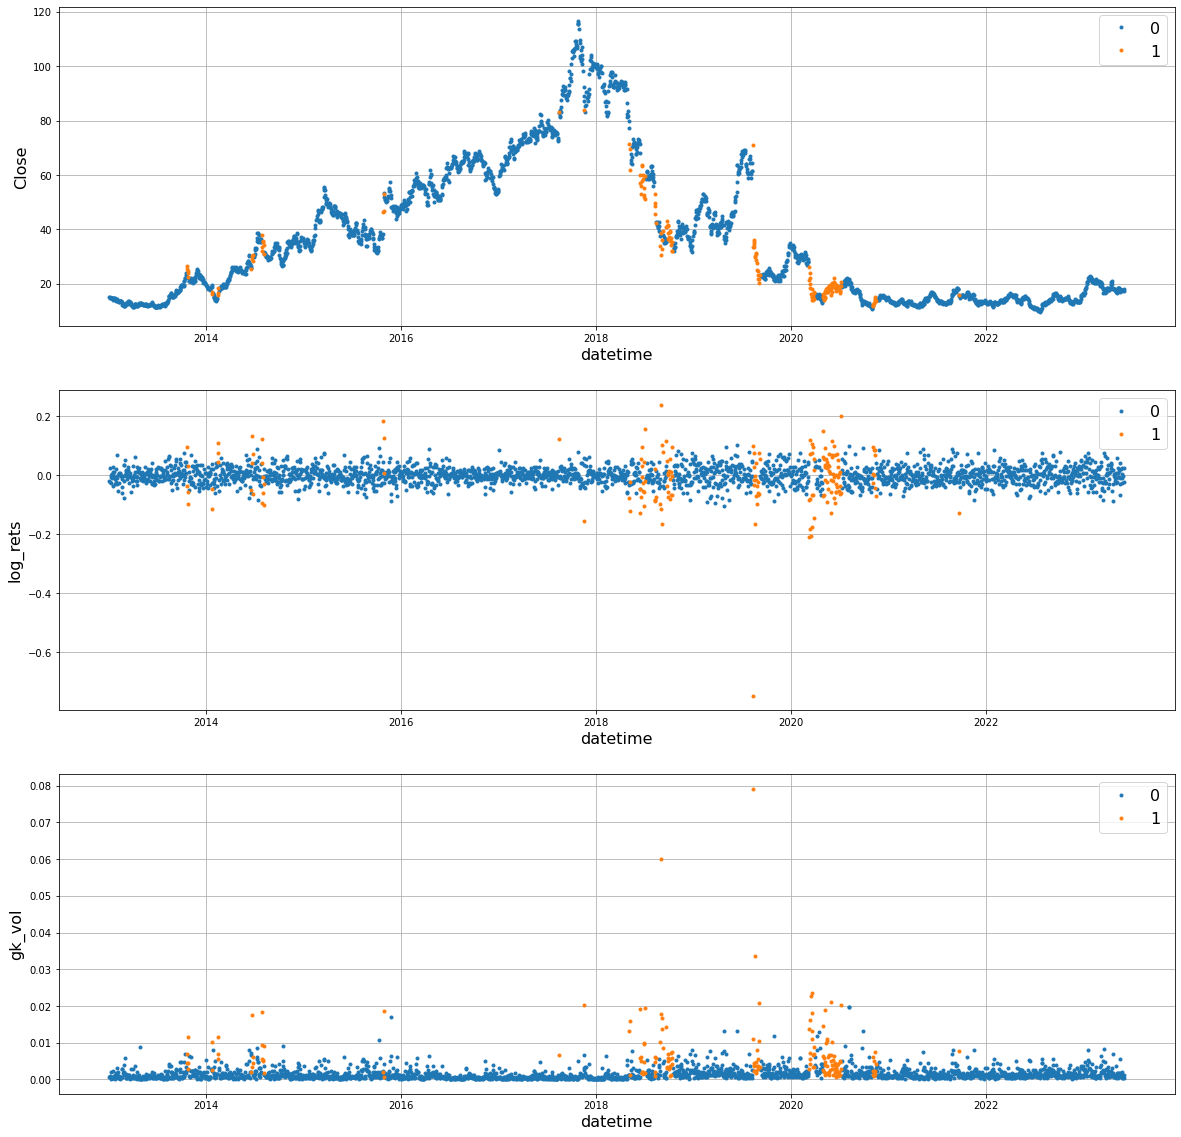

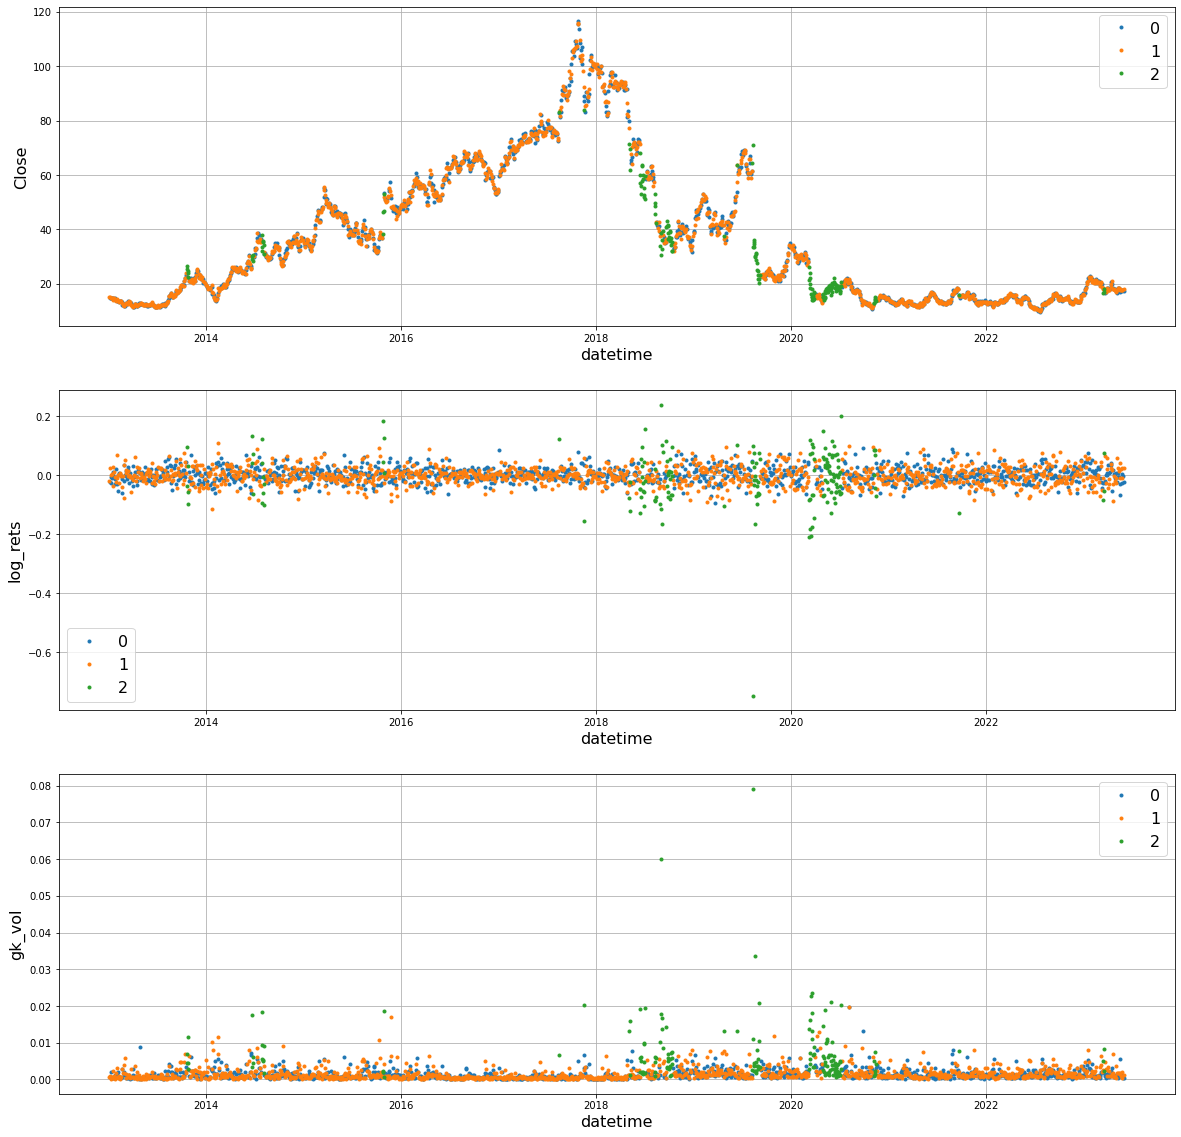

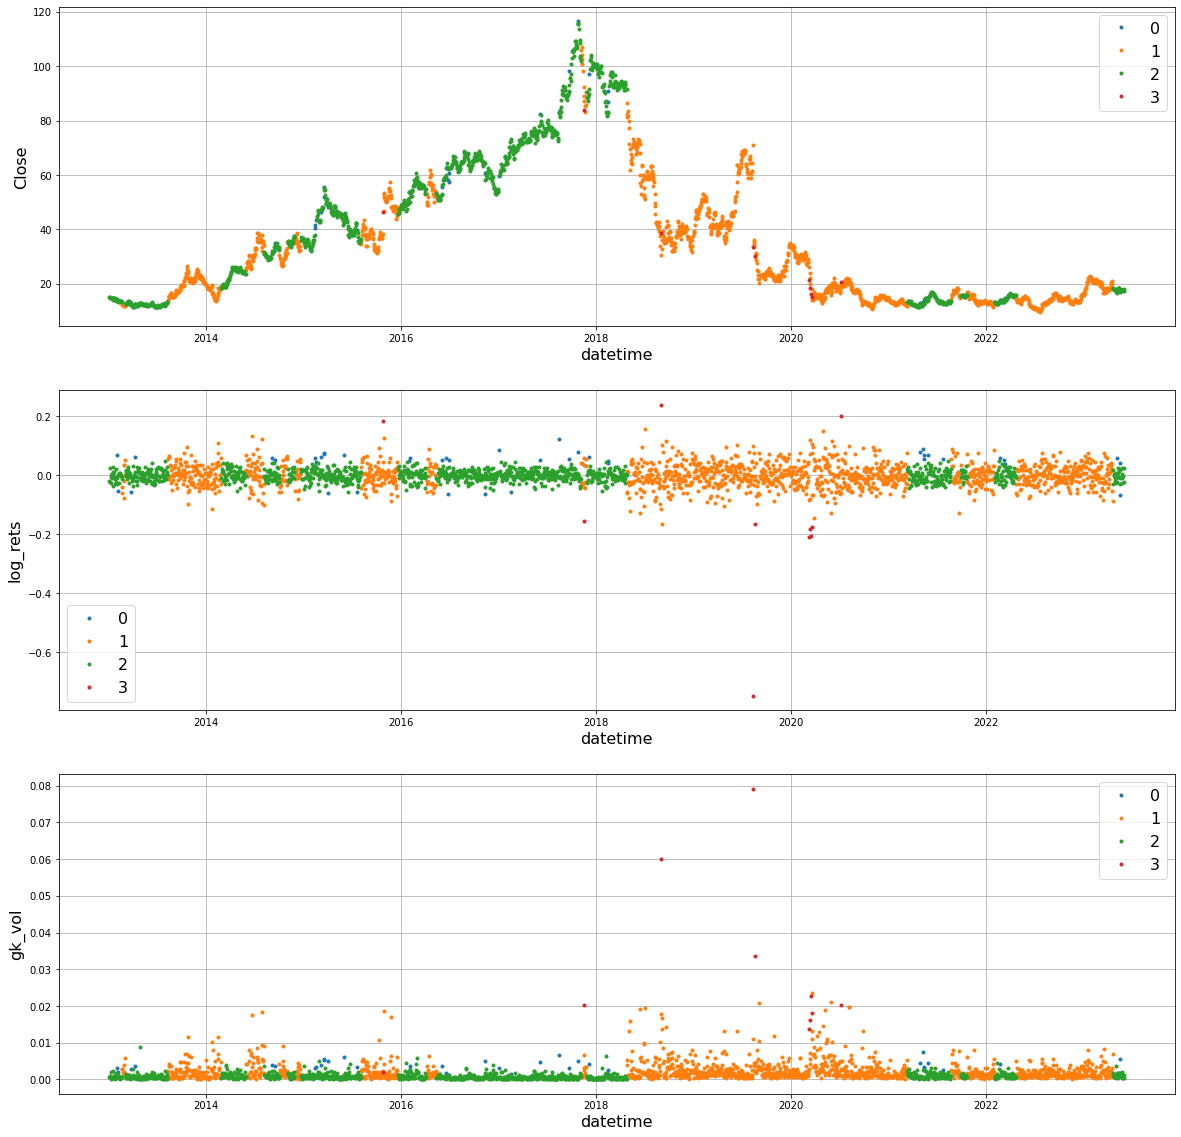

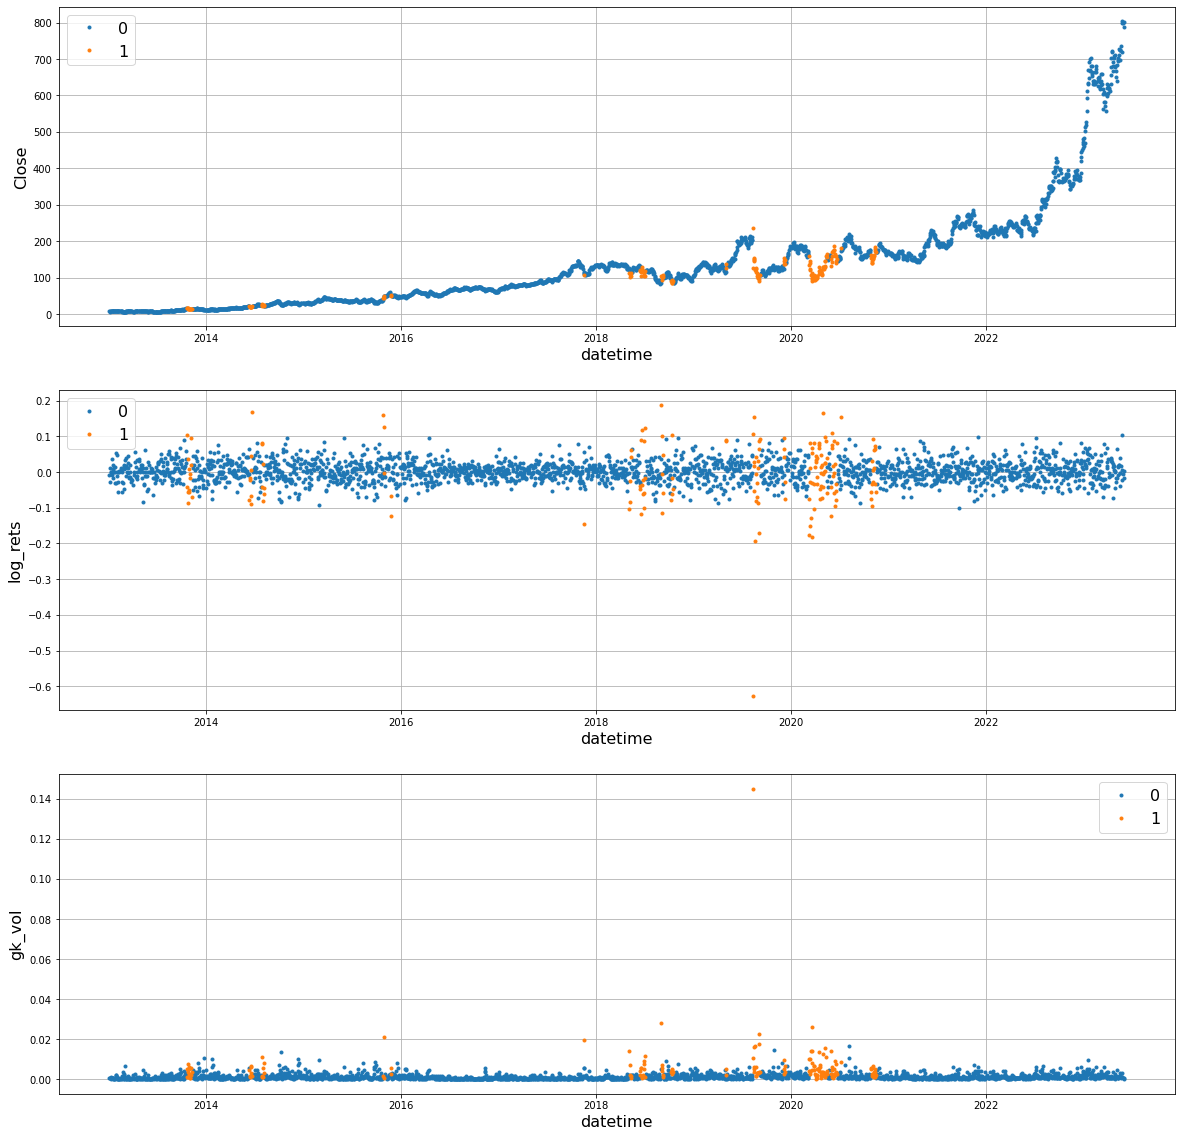

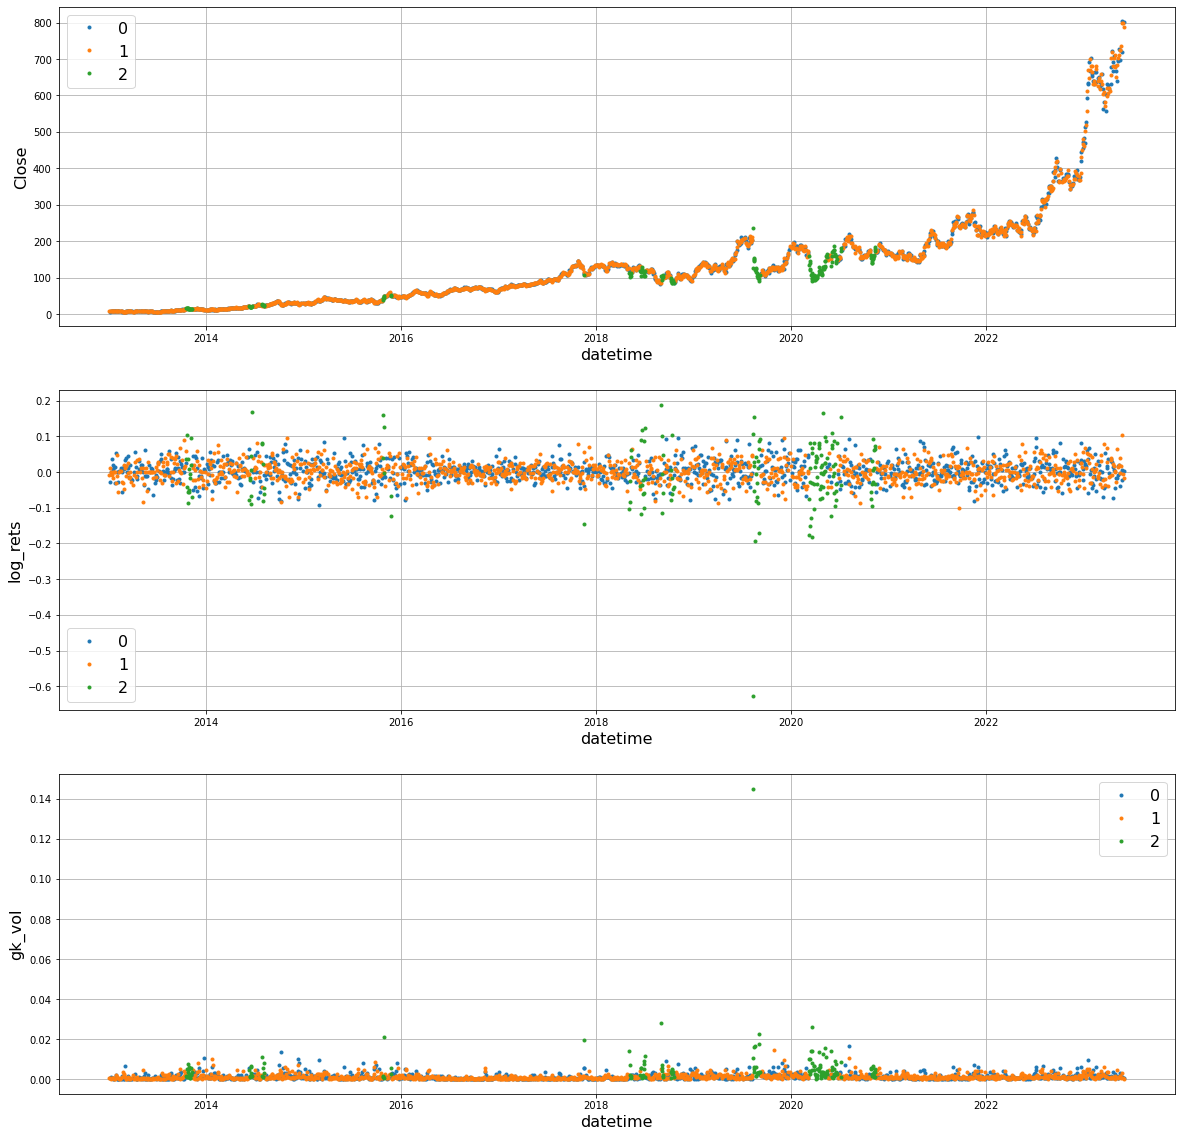

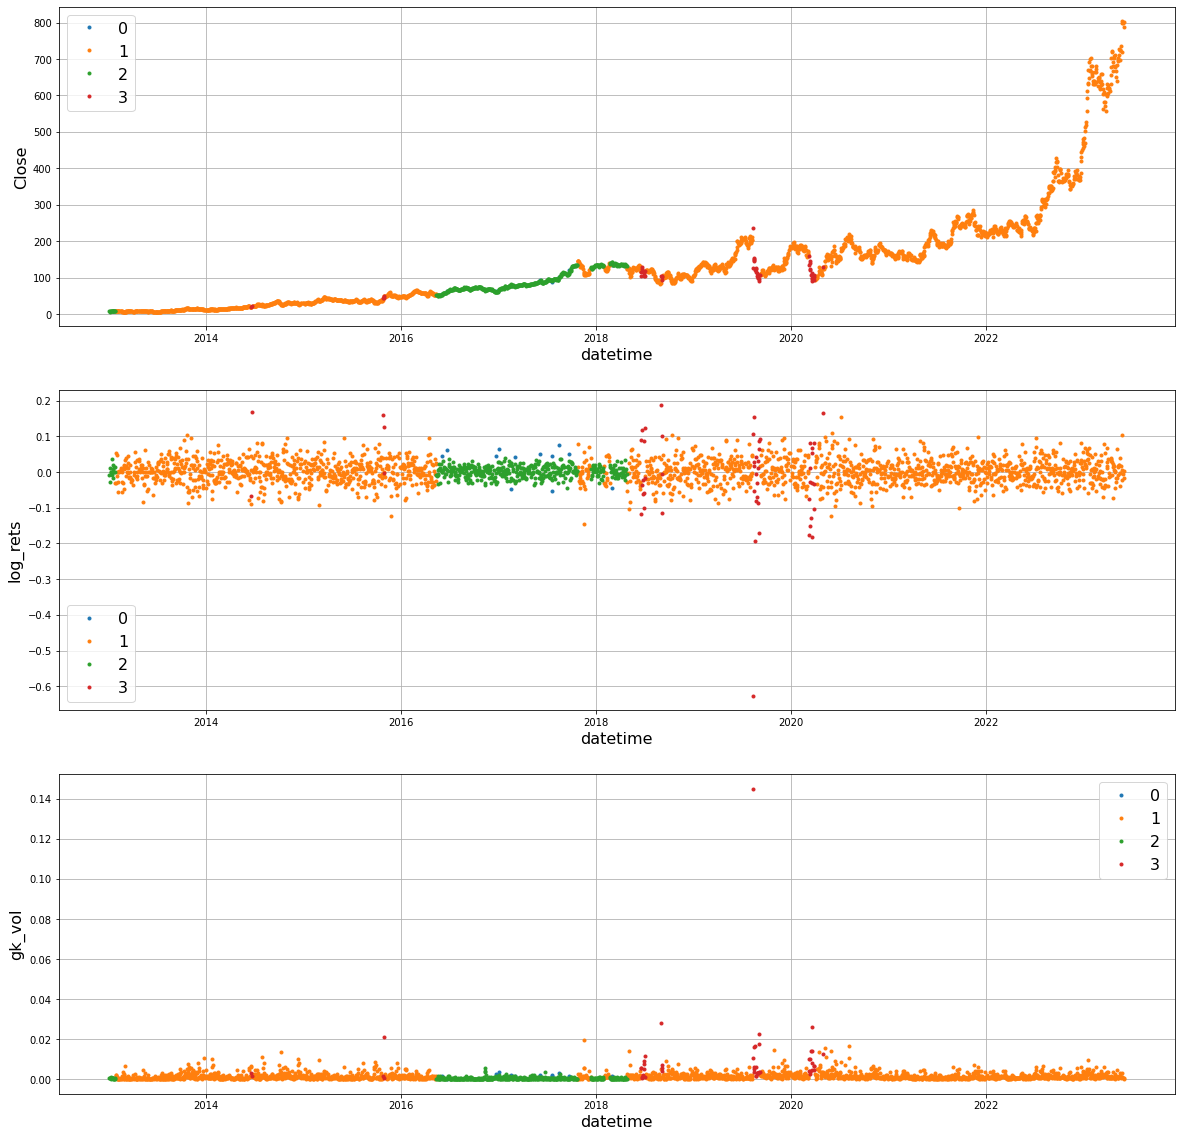

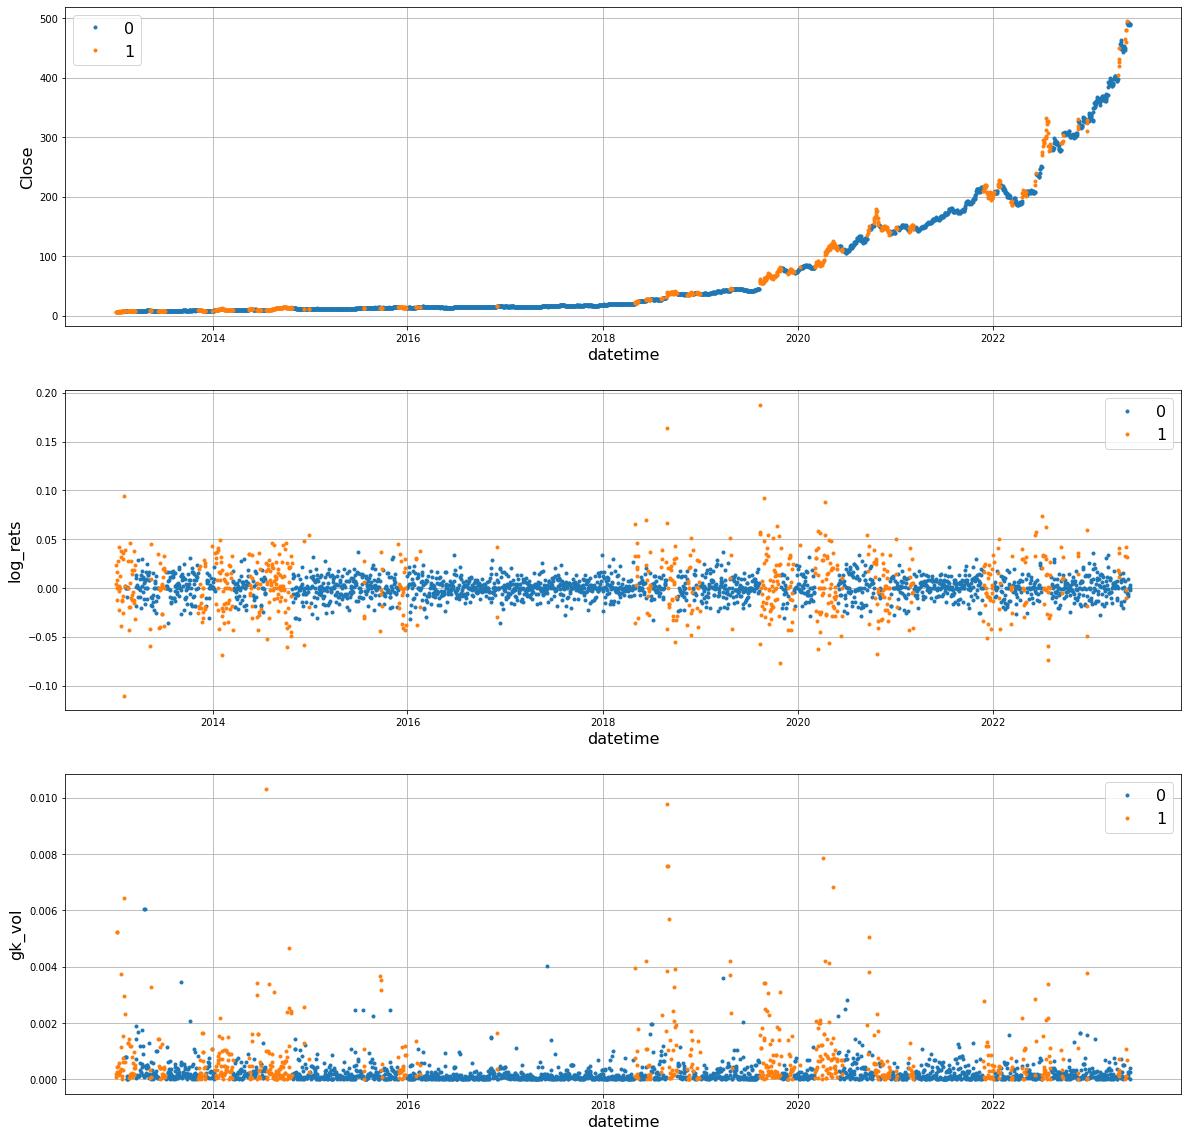

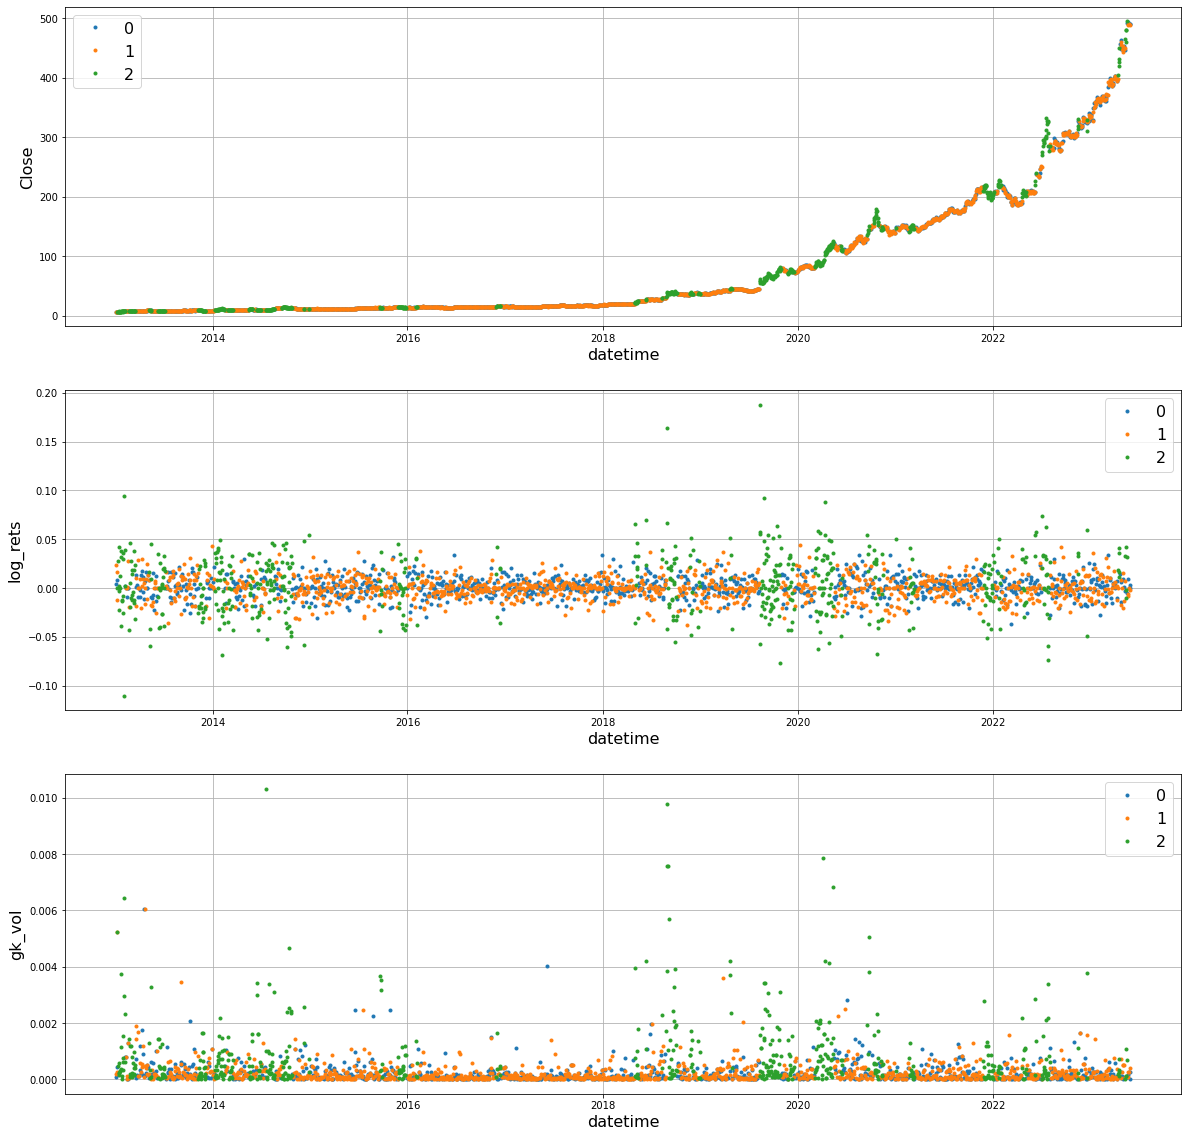

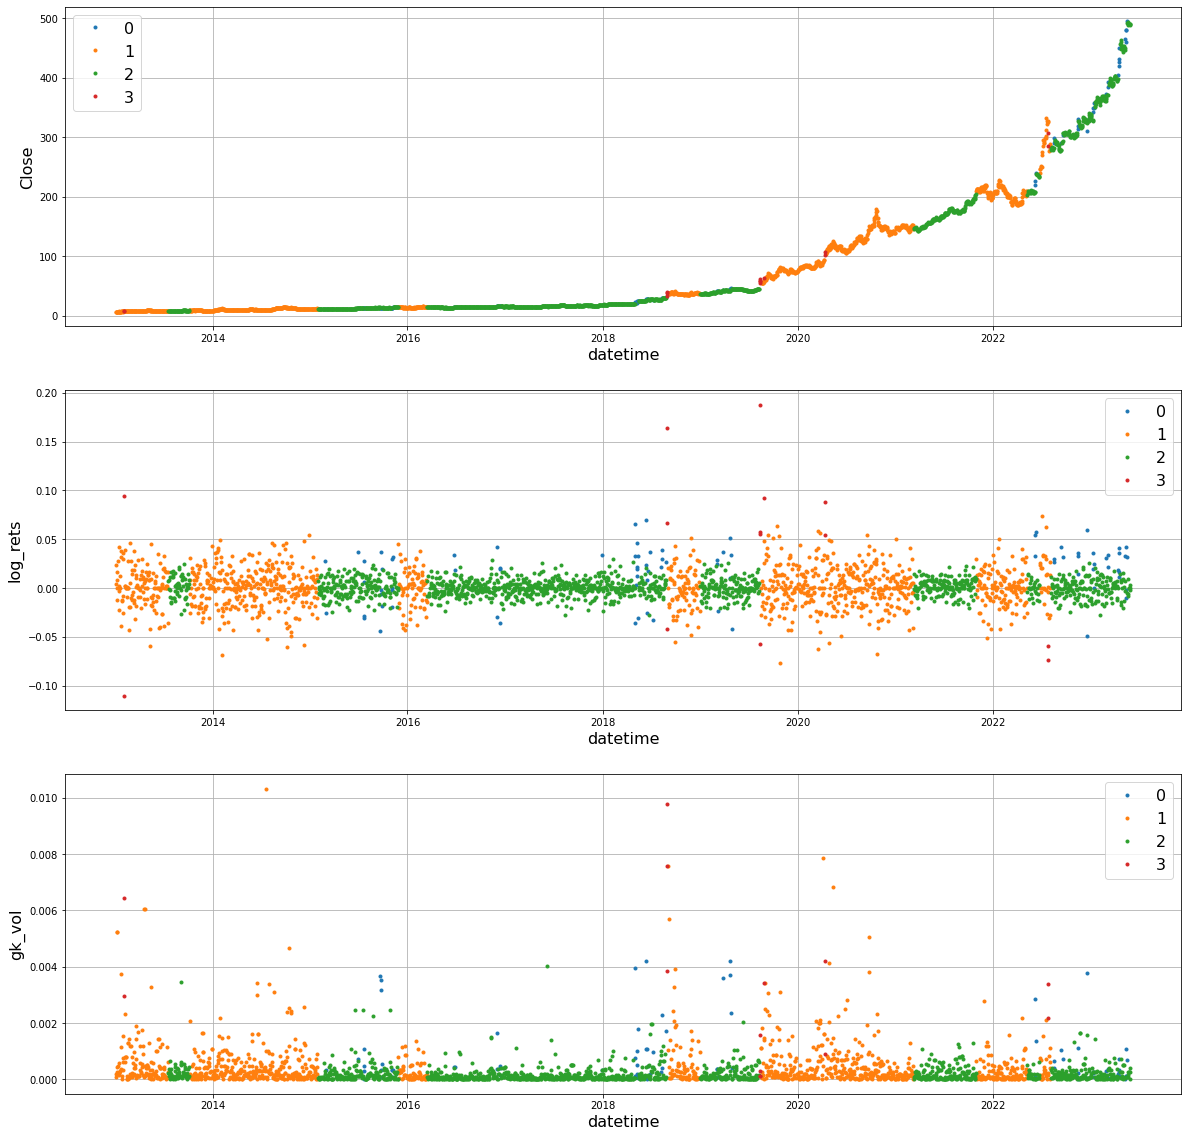

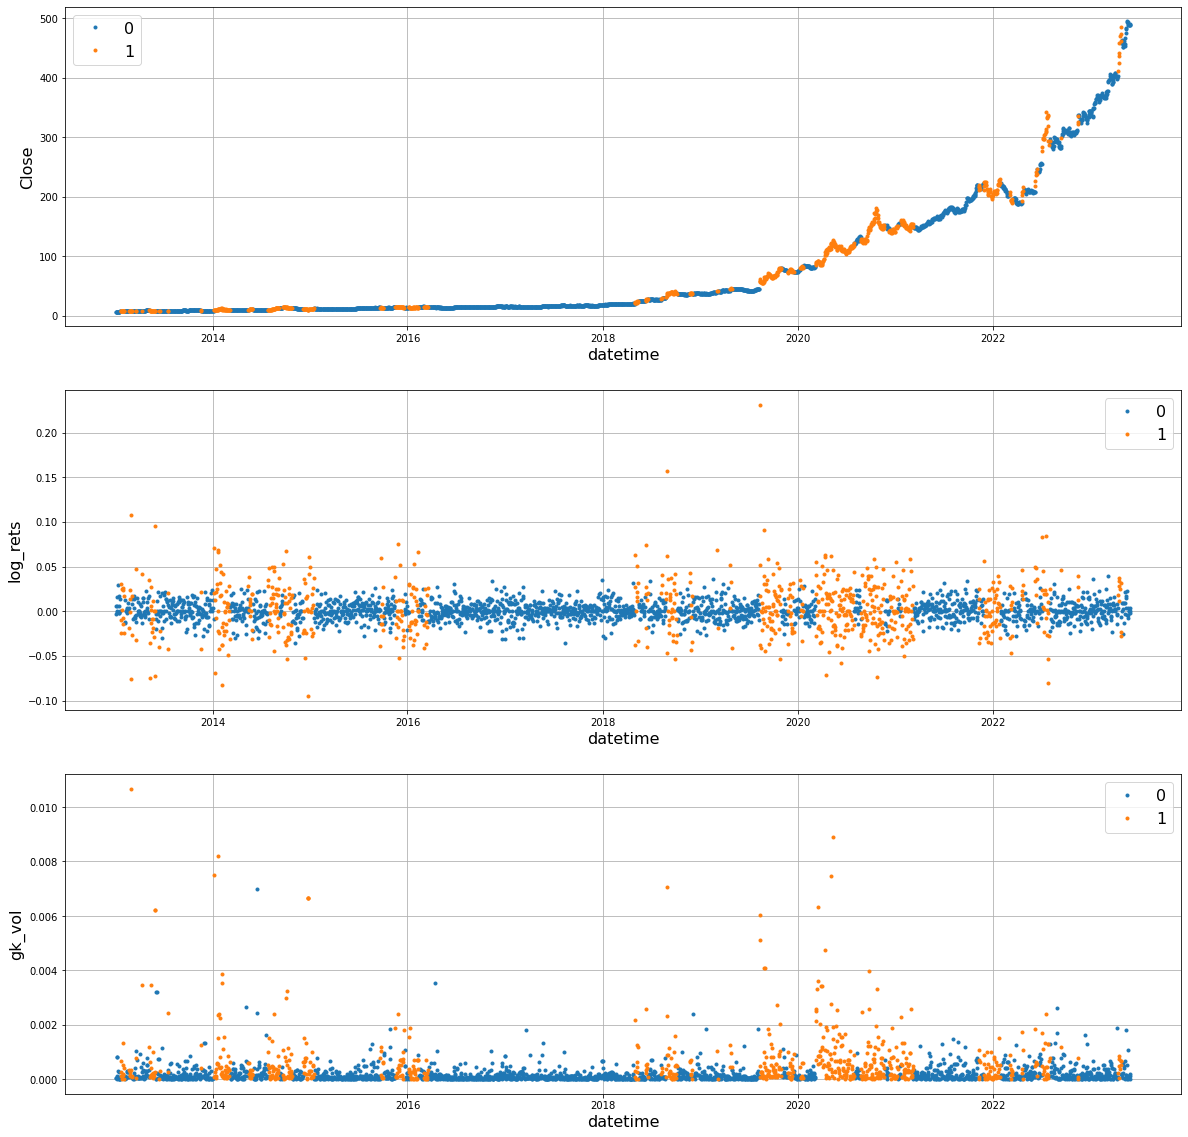

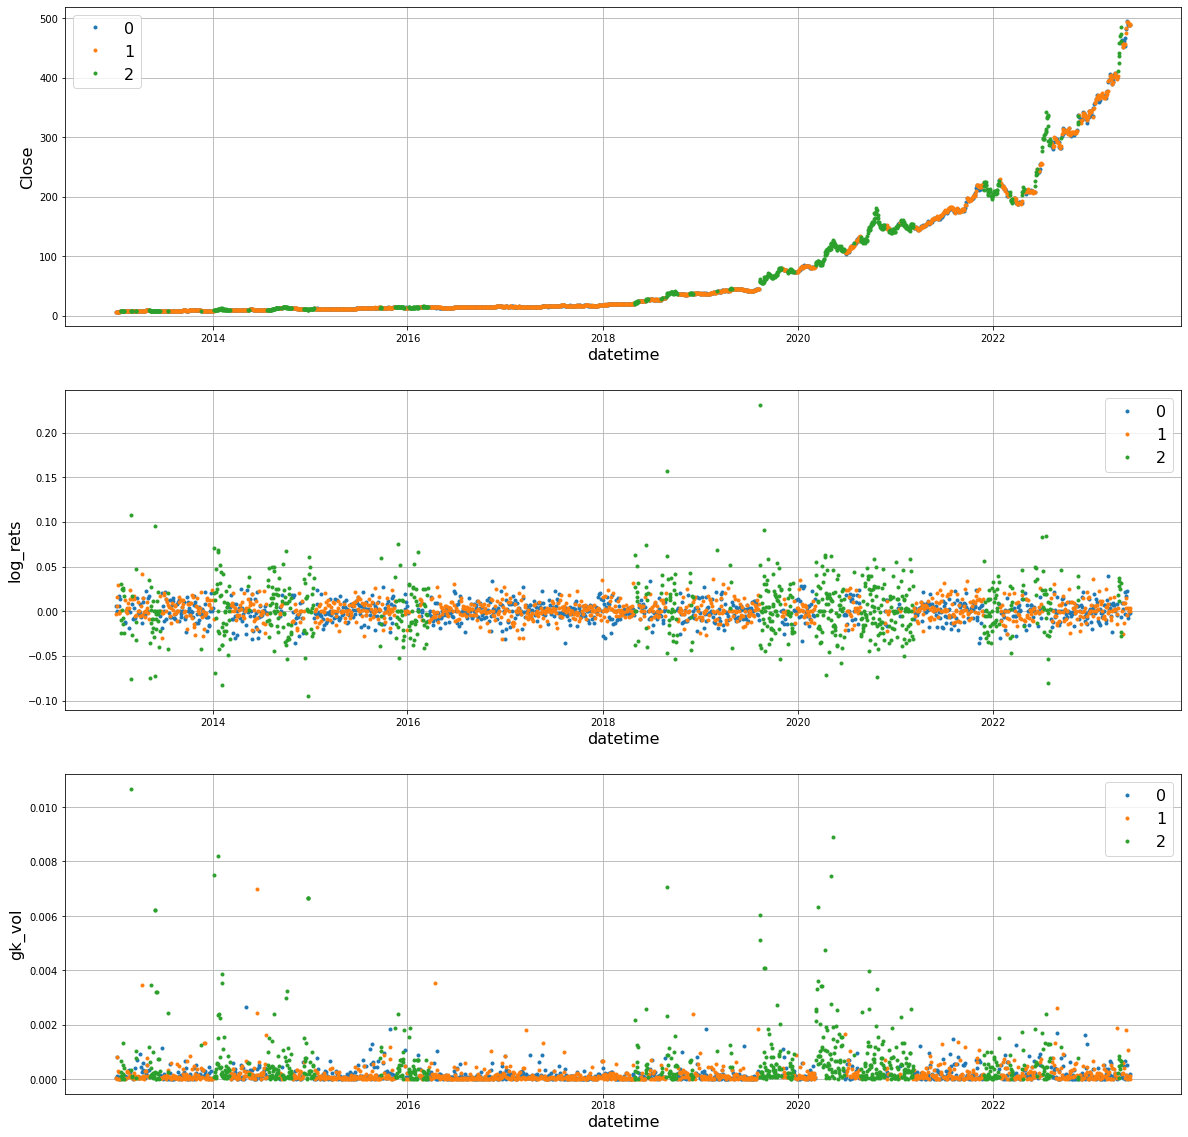

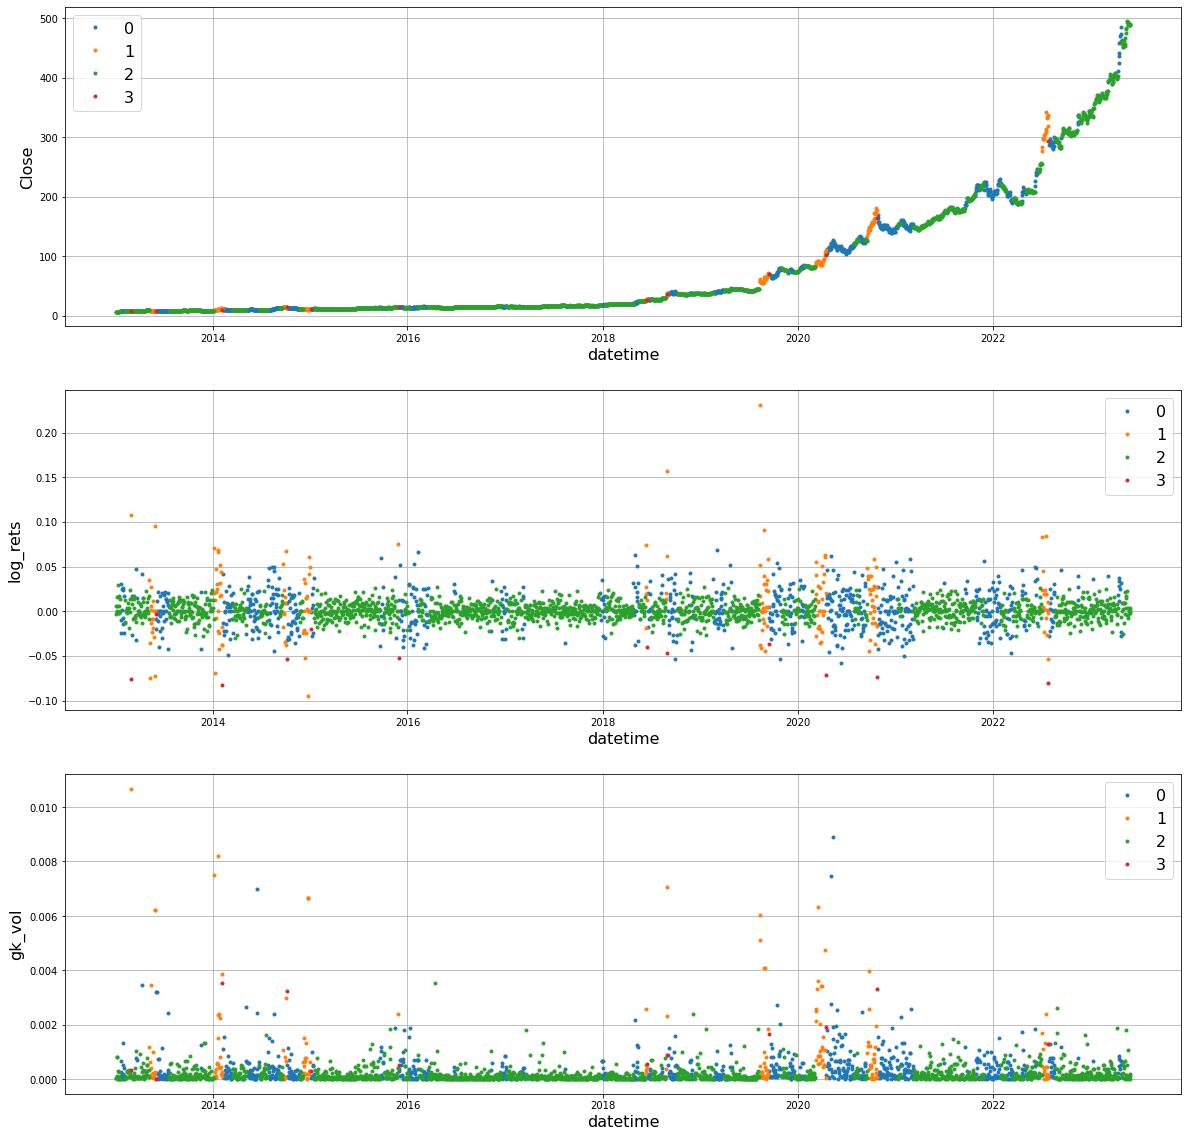

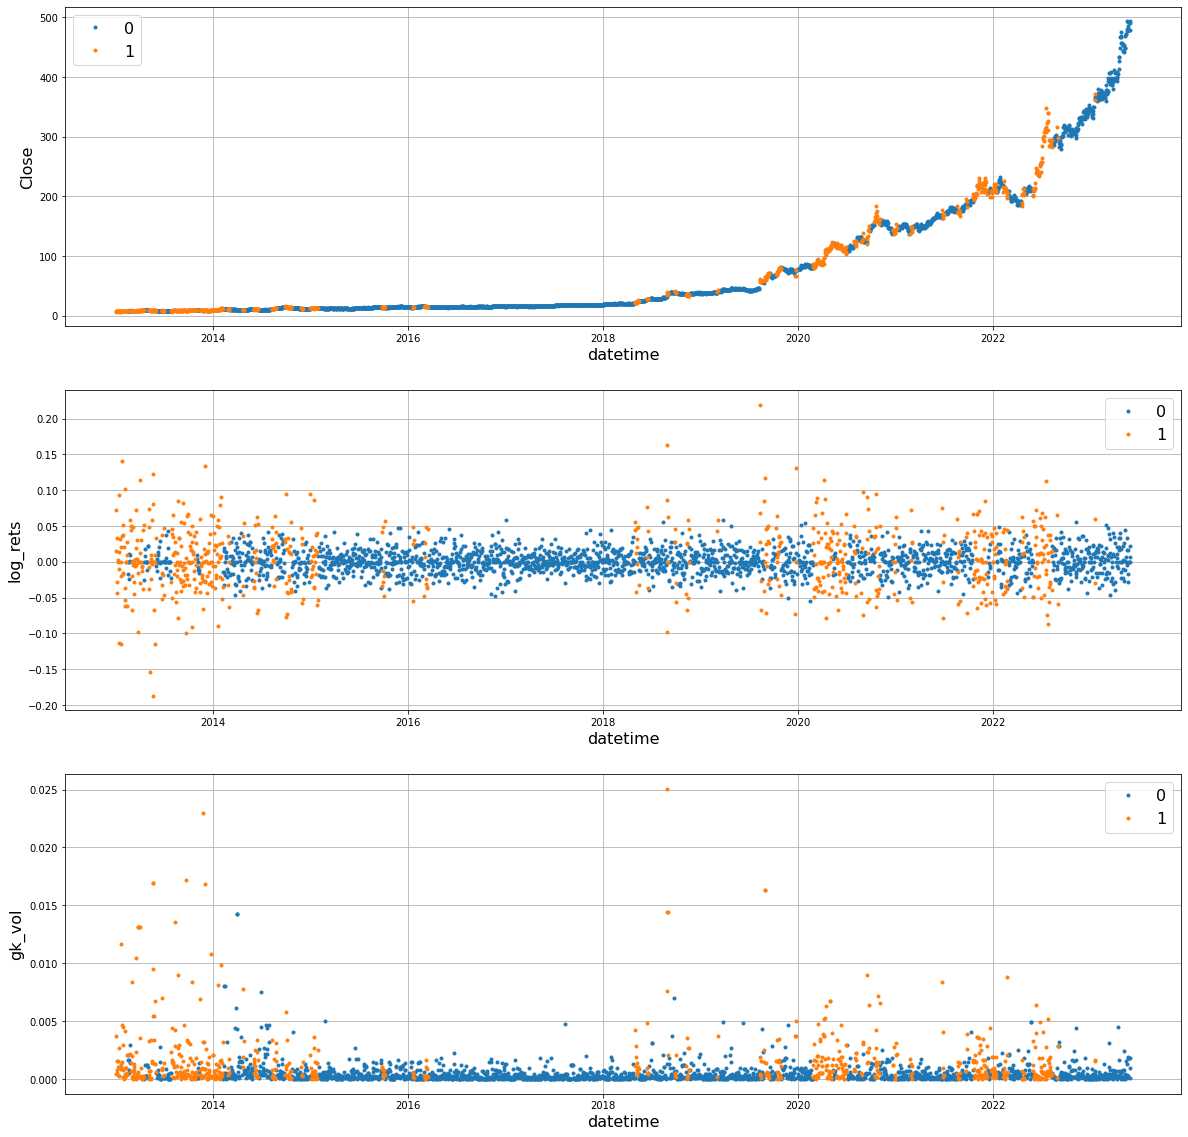

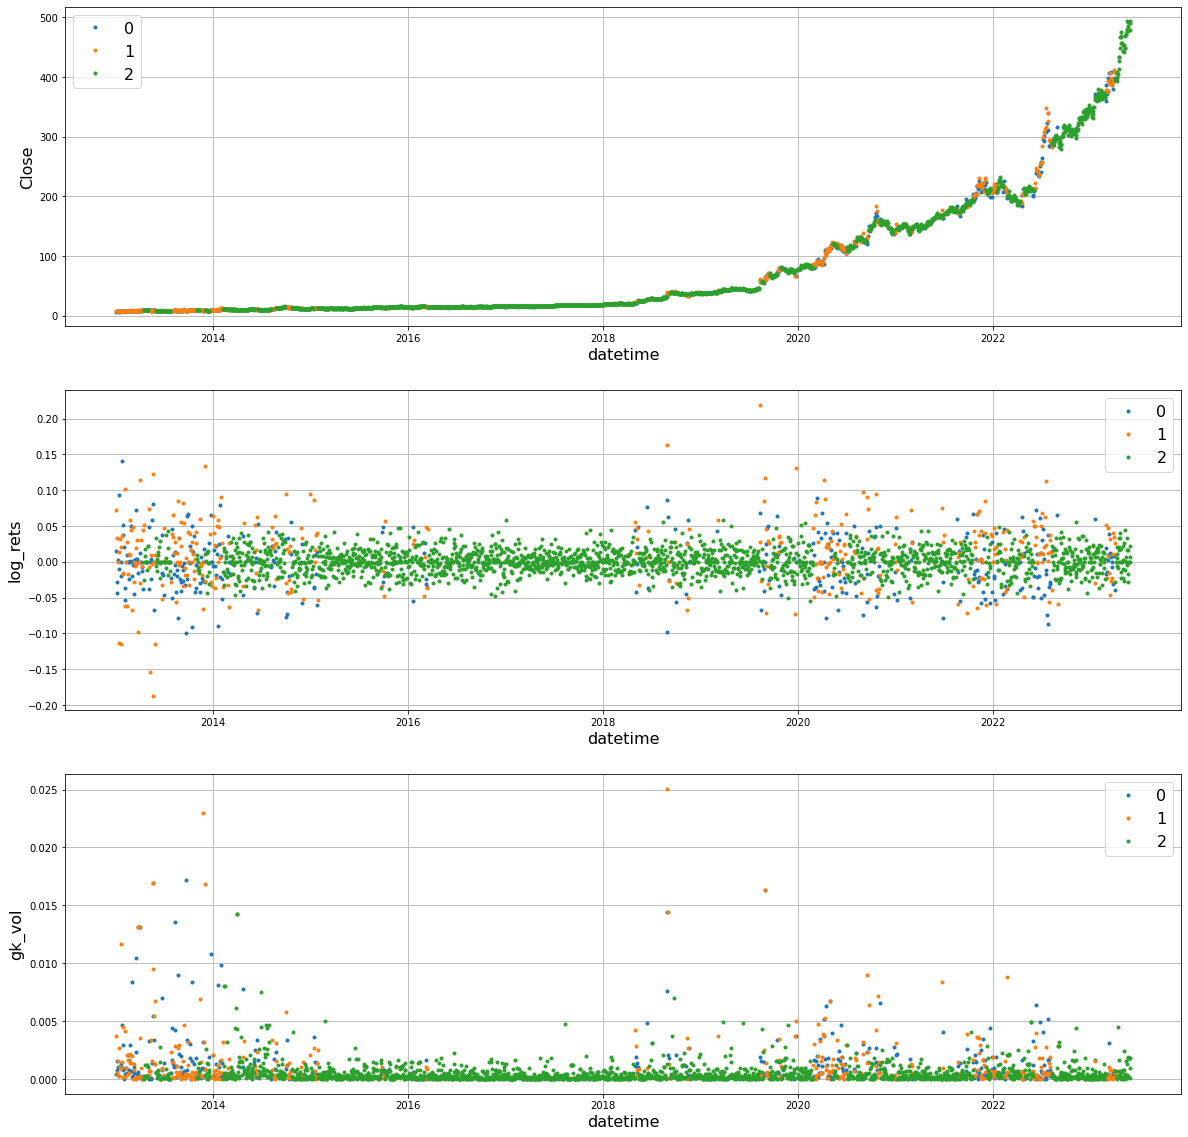

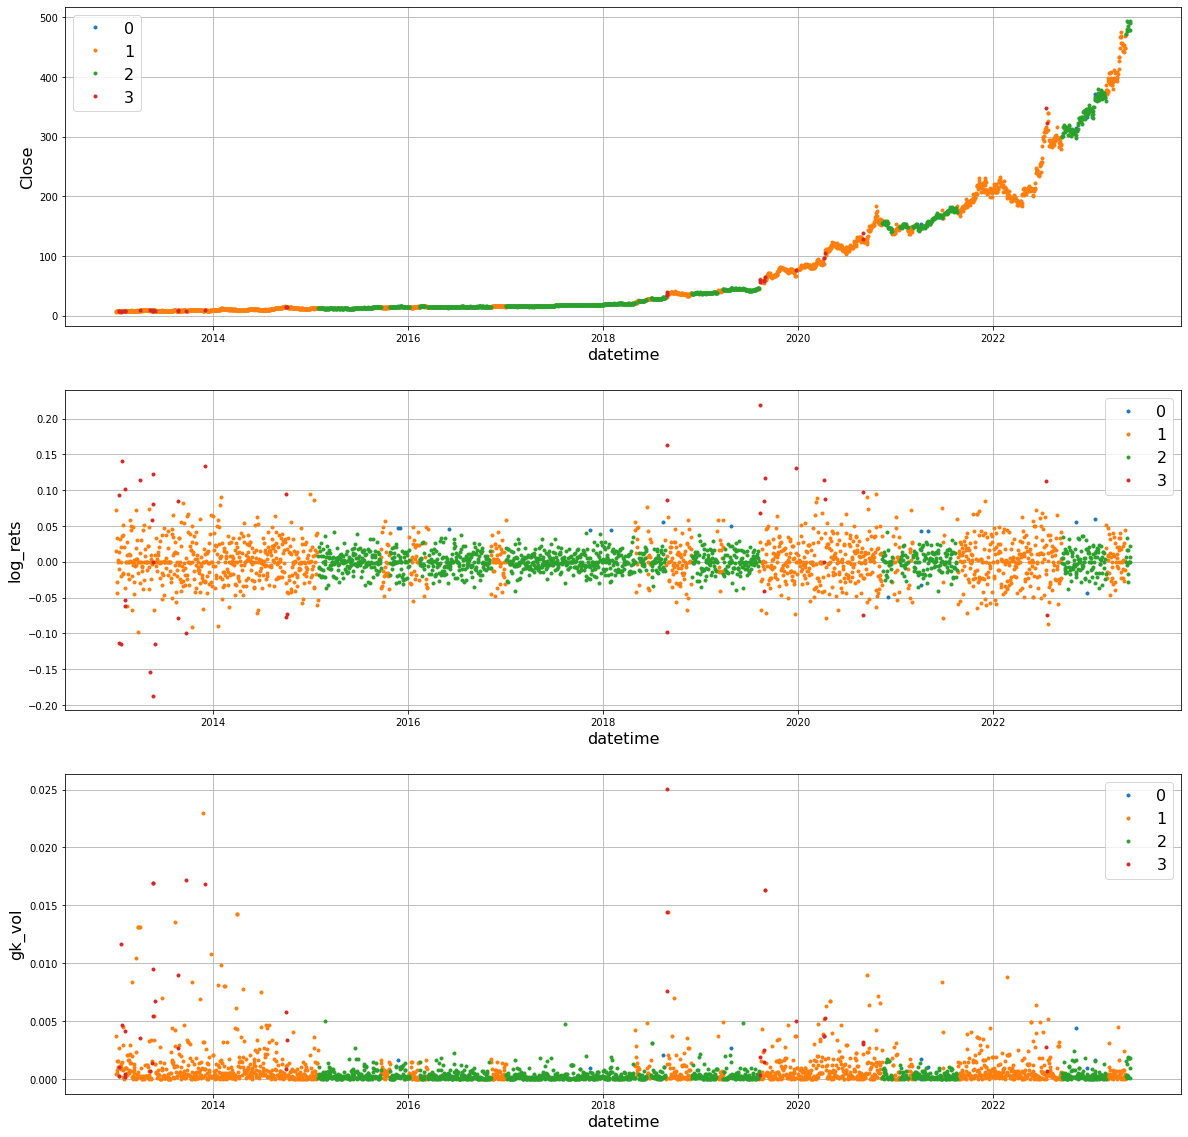

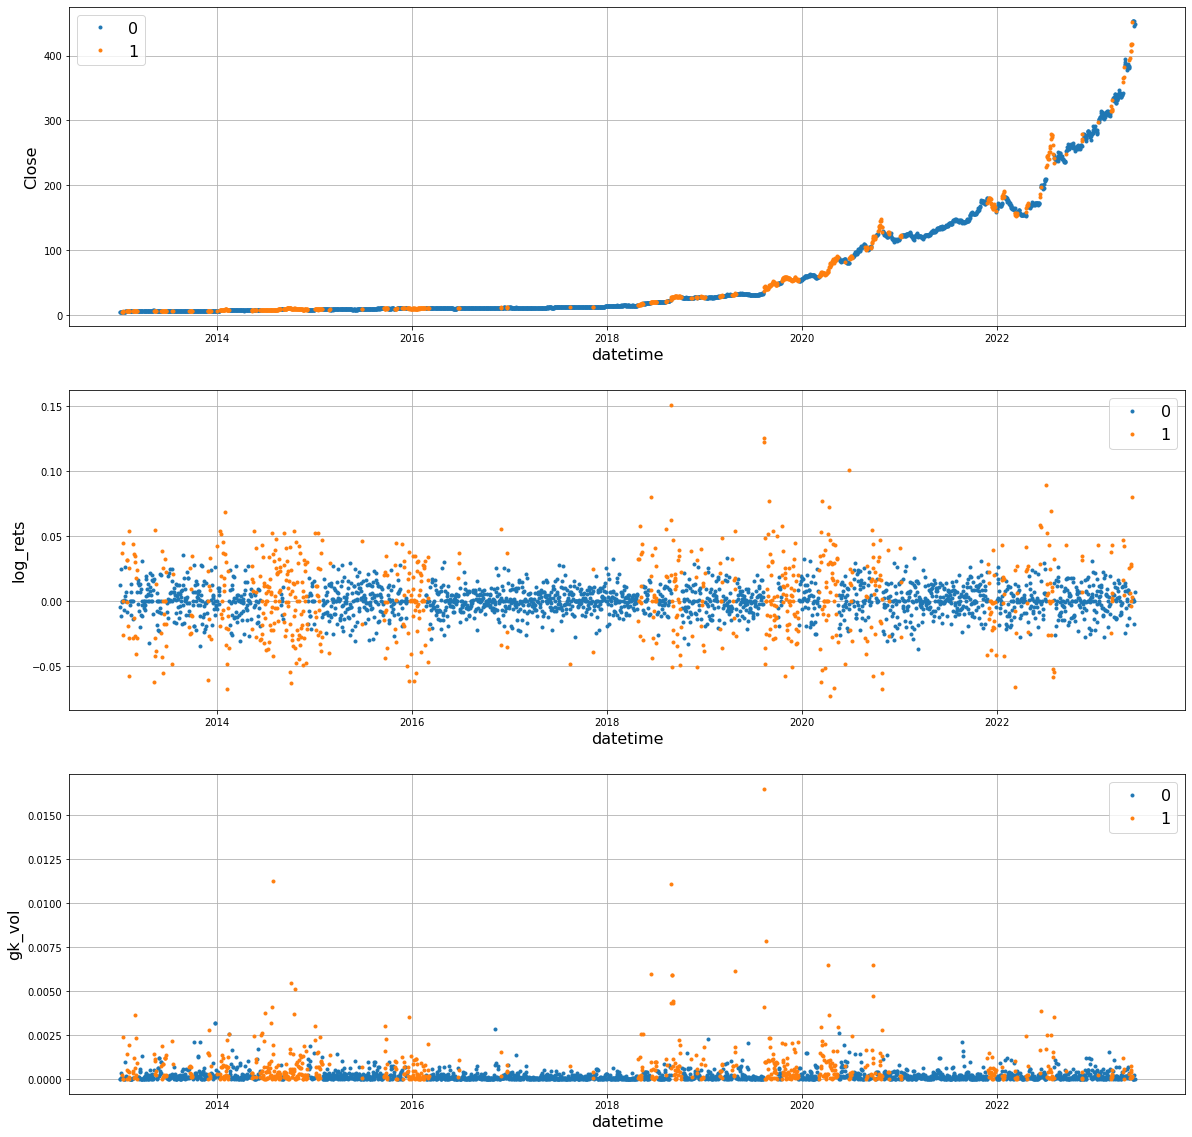

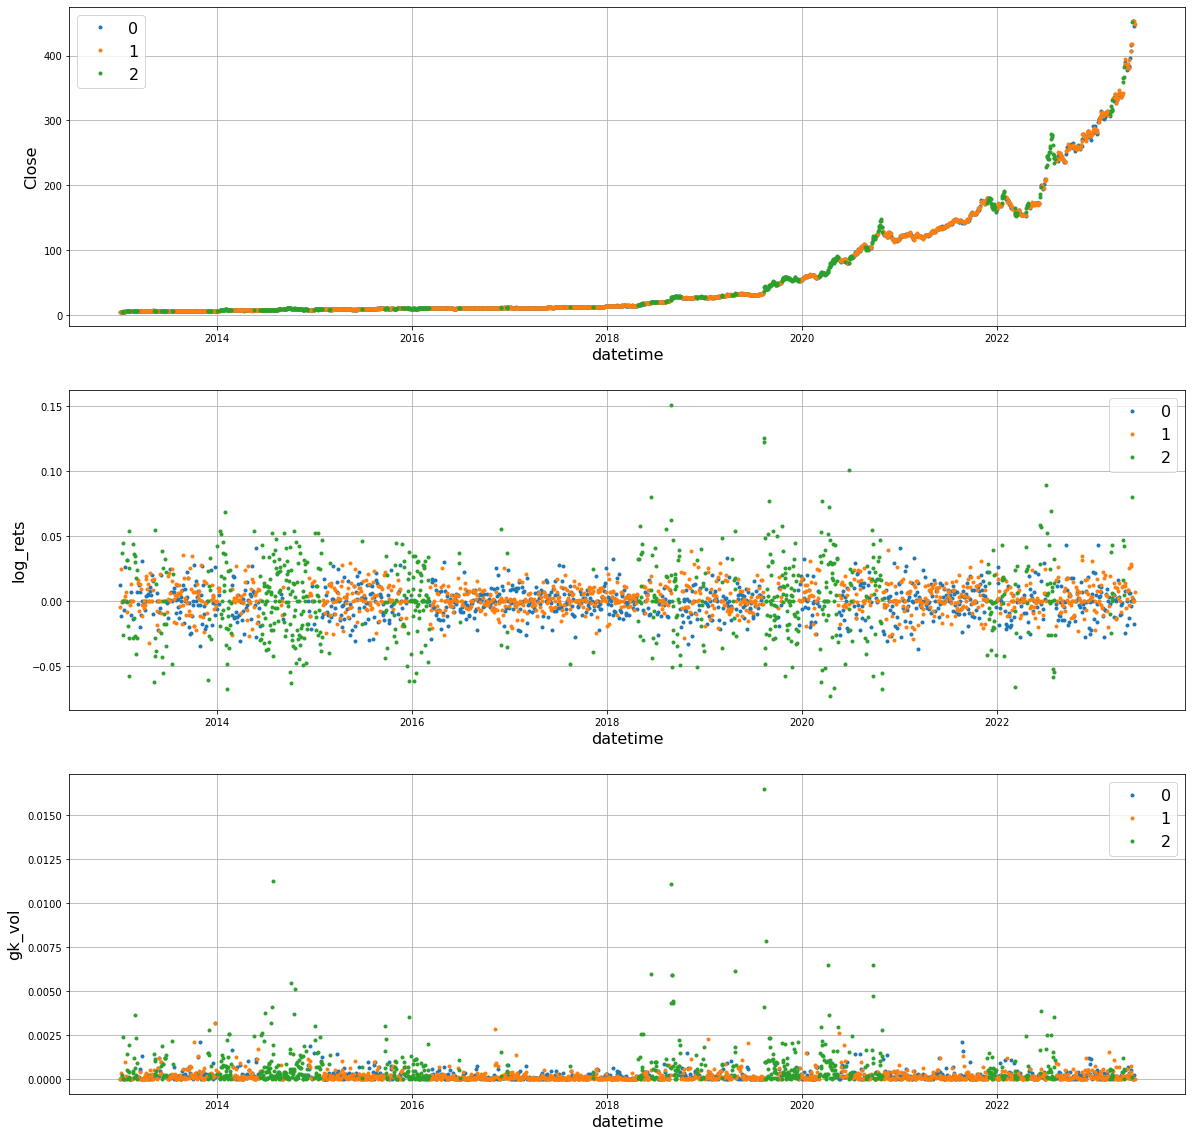

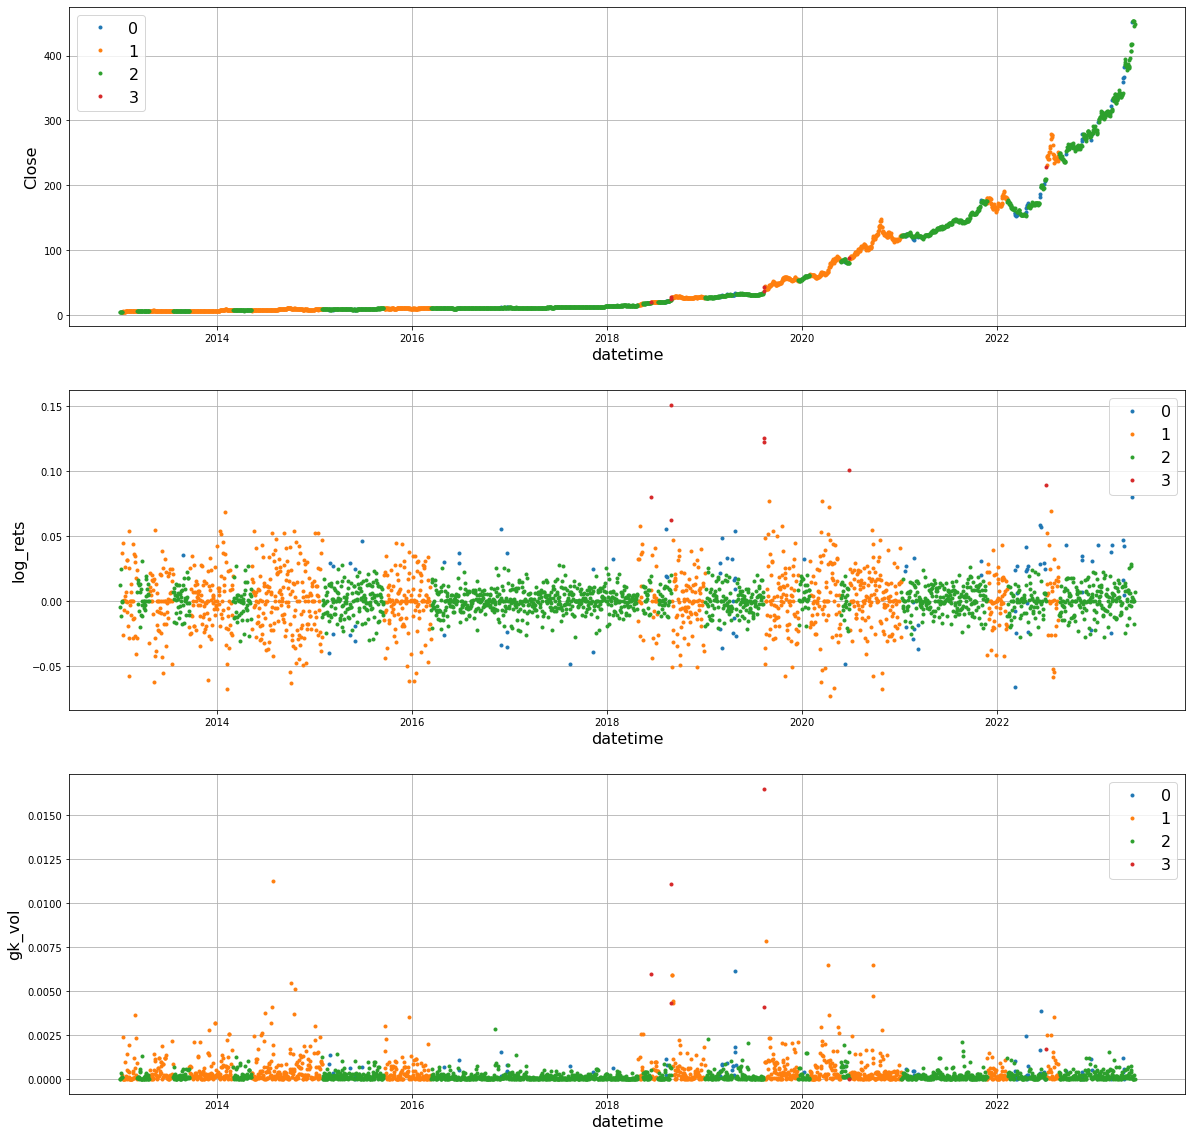

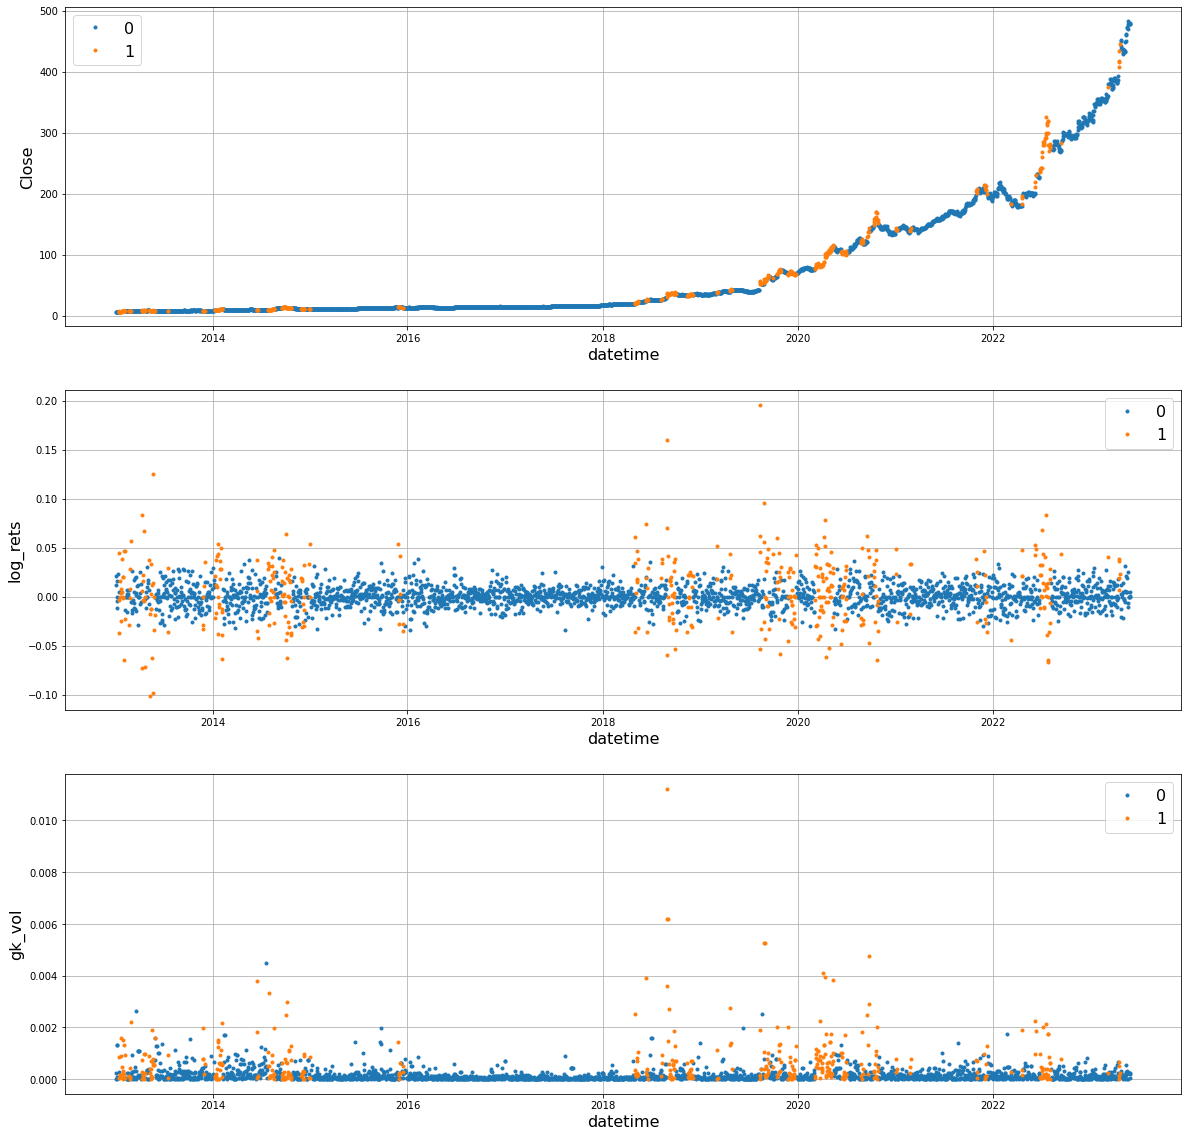

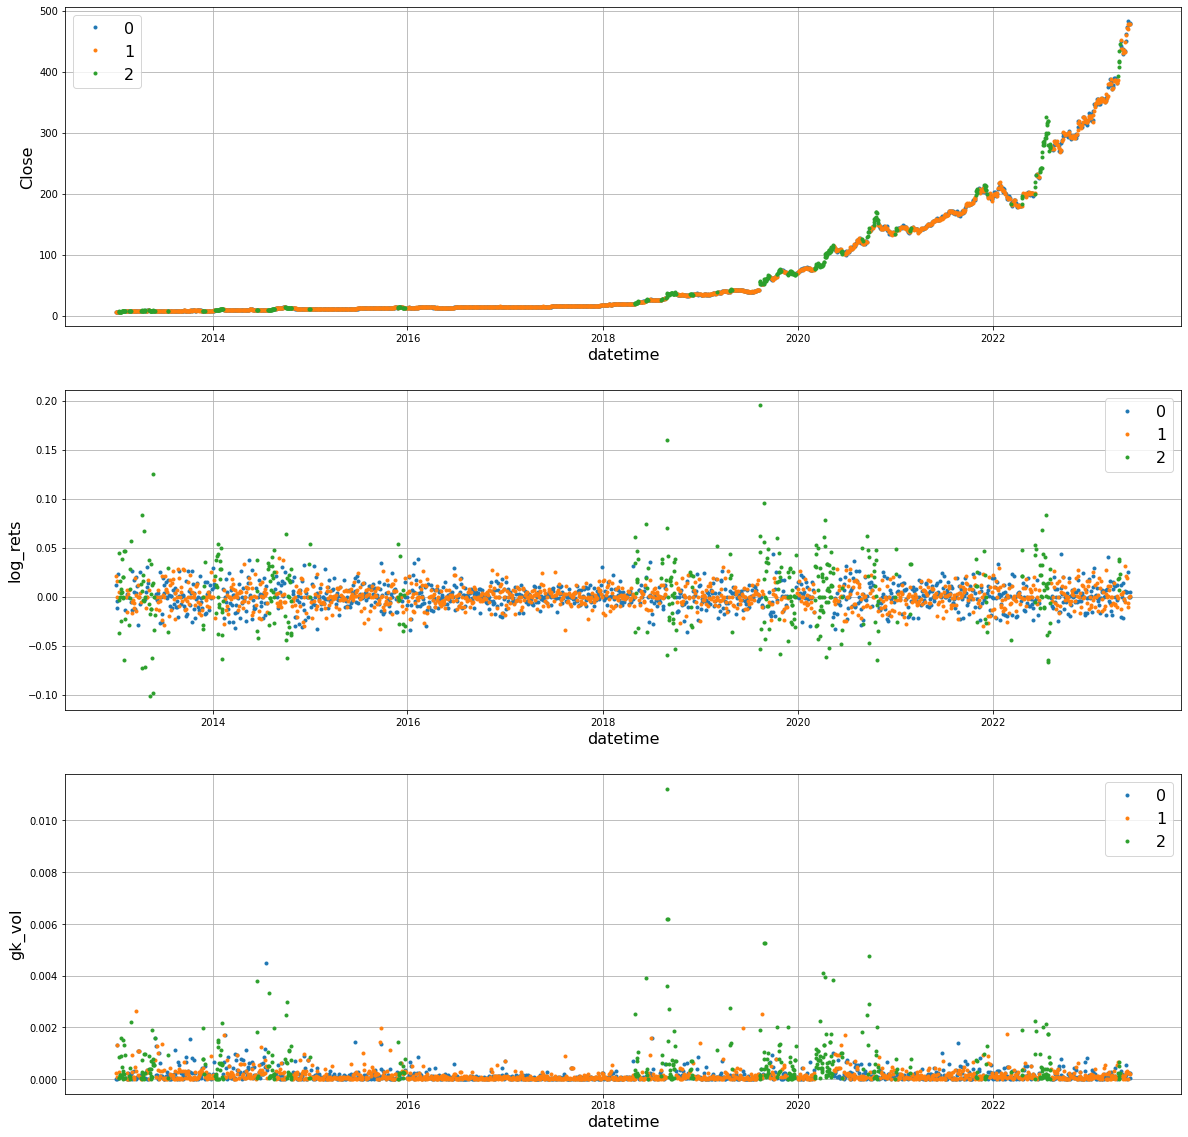

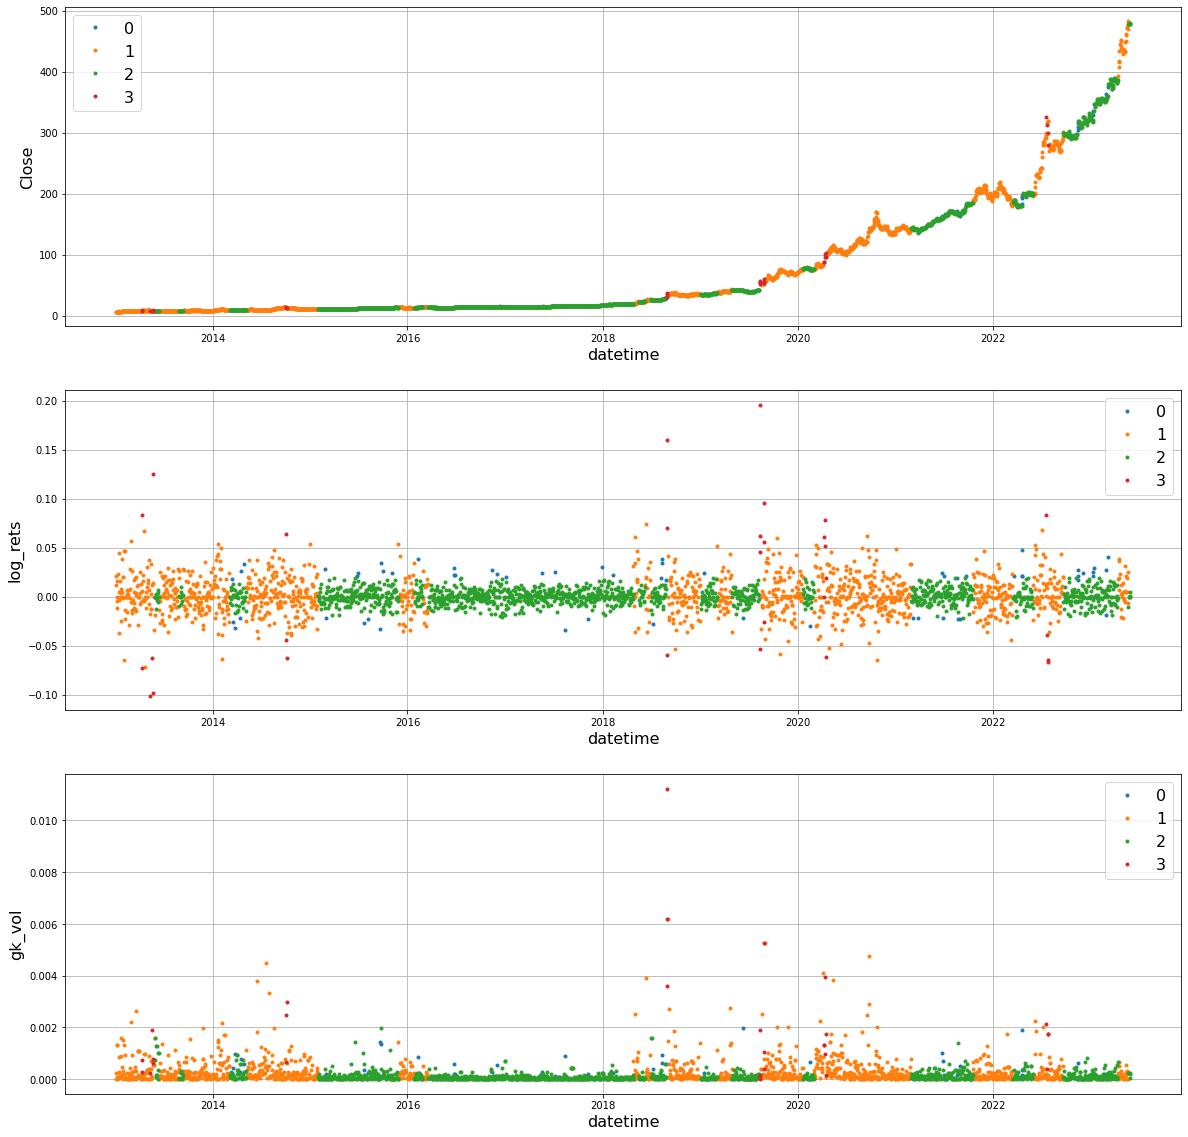

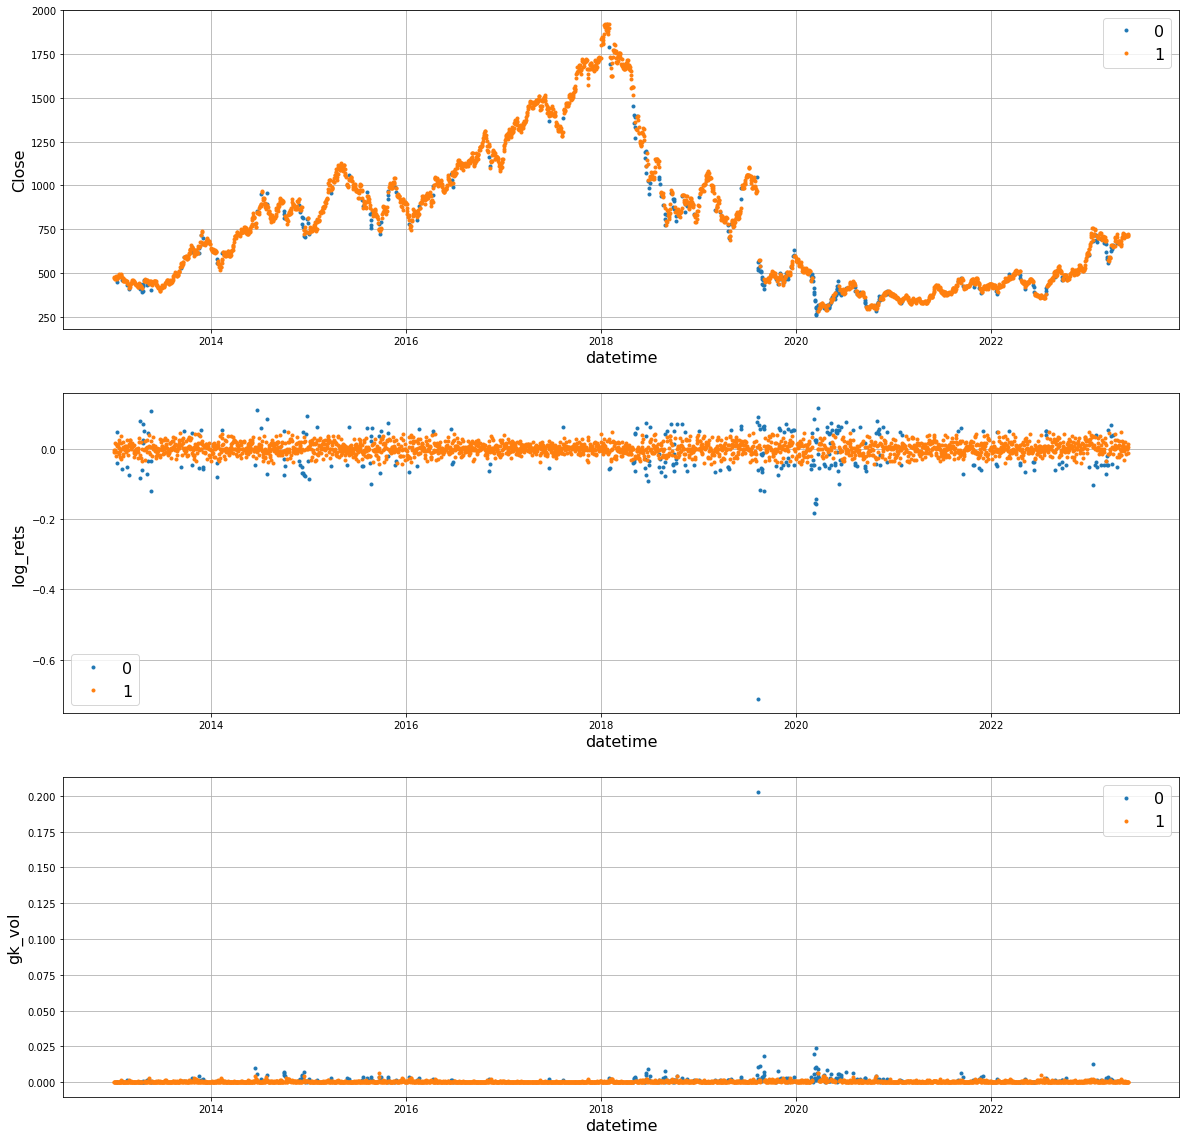

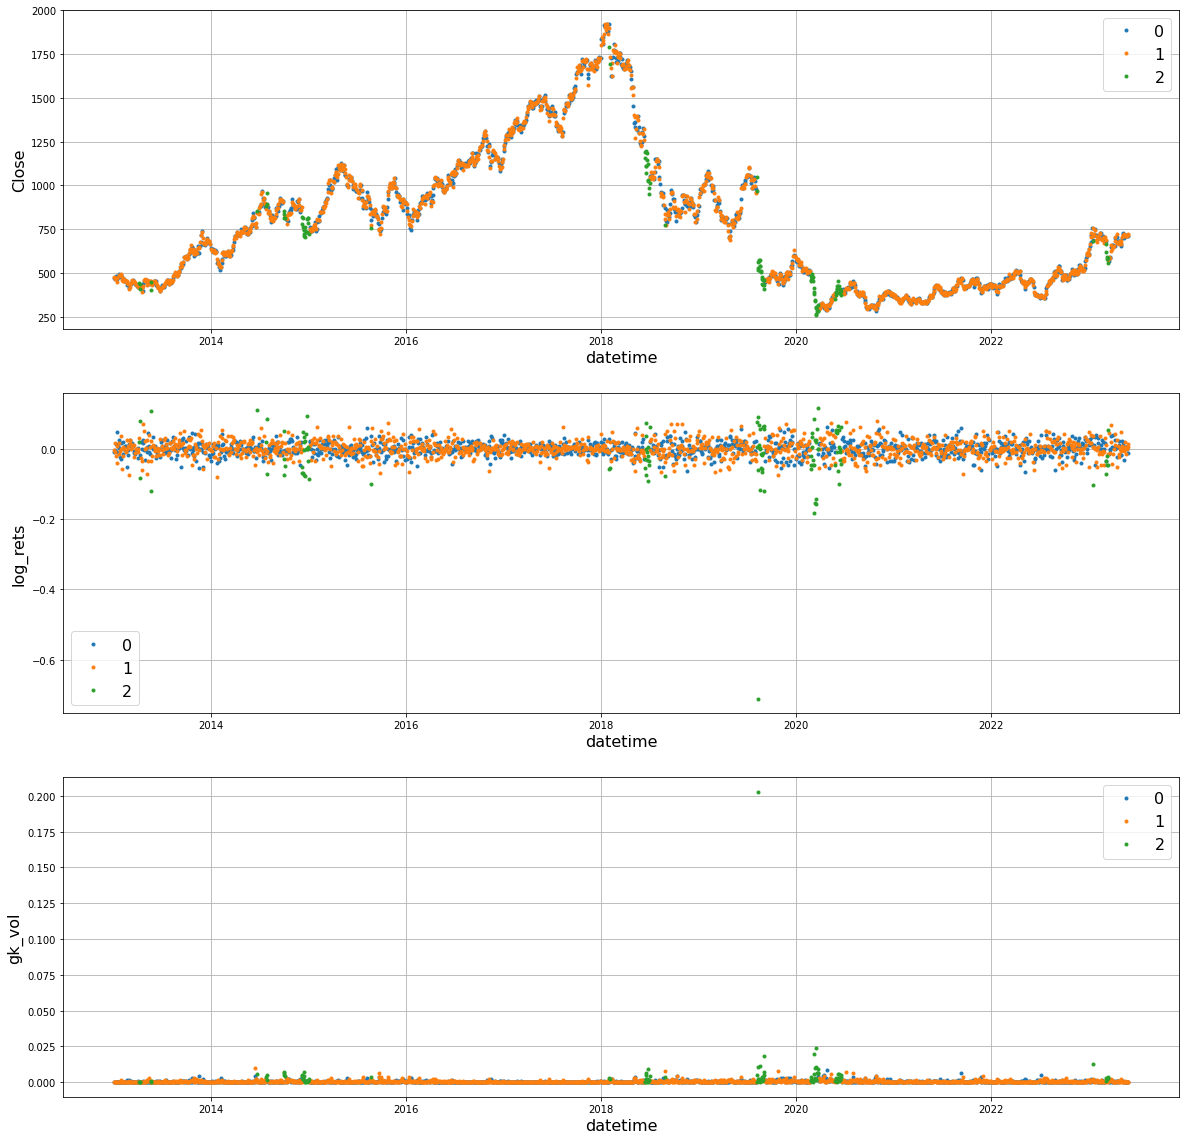

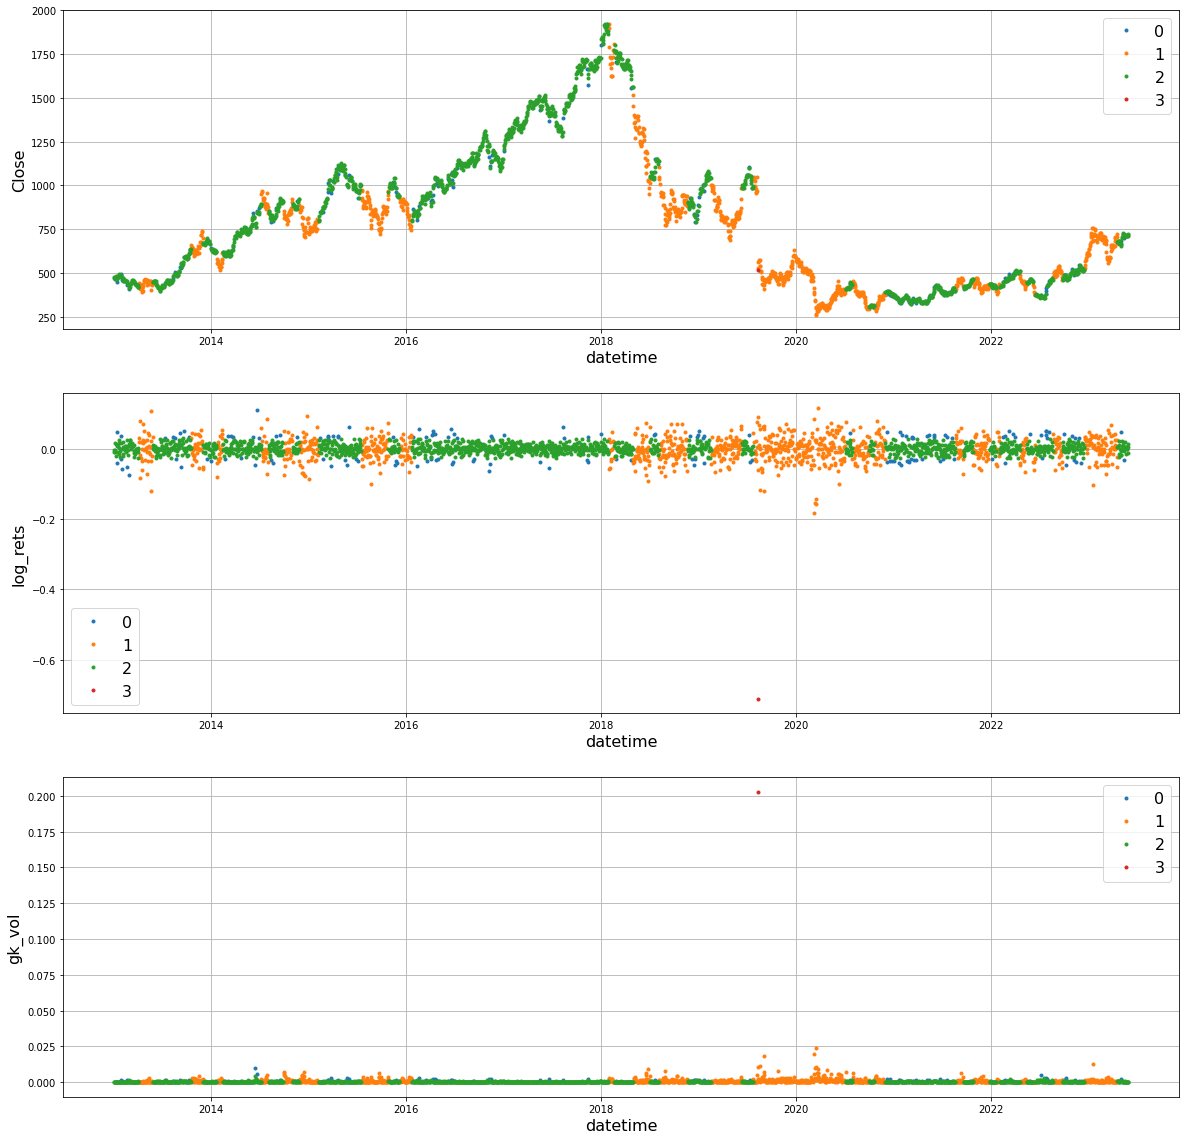

In [30]:
for key in data.keys():
    for comp in comps:
        model=models[f"{key}_{comp}_model"]
        prediction=models[f"{key}_{comp}_prediction"]
        states=set(prediction)

        plt.figure(figsize = (20, 20))

        for subplot, var in zip(range(1,4), ["Close", "log_rets", "gk_vol"]):    
            plt.subplot(3,1,subplot)
            for i in set(prediction):
                state = (prediction == i)
                x = data[key].index[state]
                y = data[key][var].iloc[state]
                plt.plot(x, y, '.')
            plt.legend(states, fontsize=16)
            plt.grid(True)
            plt.xlabel("datetime", fontsize=16)
            plt.ylabel(var, fontsize=16)

        plt.savefig(os.path.join(resultsroute, "graphs", 
                                 f"{comp}_states", 
                                 f"{key}_model_{comp}.png"))

plt.show()

## HMM Selection

Selecting the Number of States in Hidden Markov Models: Pragmatic Solutions Illustrated Using Animal Movement
https://sci-hub.st/10.1007/s13253-017-0283-8